# Setup

## Import Library

In [1]:
import os
import asyncio
import nest_asyncio
import importlib
import time
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnetv2_preprocess
from tensorflow.keras import layers, models
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.optimizers import Adam
from PIL import Image
from dotenv import load_dotenv
from telegram import Bot, InputFile
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from tensorflow.keras.applications import (
    MobileNetV3Small,
    MobileNetV3Large,
    EfficientNetV2B0,
    EfficientNetV2B1,
    EfficientNetV2B2,
    EfficientNetV2B3,
    EfficientNetV2S,
    EfficientNetV2M,
    EfficientNetV2L
)

from efficientNet.efficientnet_v2_modifikasi import (
    EfficientNetV2B0Modifikasi,
    EfficientNetV2B1Modifikasi,
    EfficientNetV2B2Modifikasi,
    EfficientNetV2B3Modifikasi,
)

importlib.reload(importlib.import_module('efficientNet.efficientnet_v2_modifikasi'))

2024-12-24 03:41:28.649441: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 03:41:28.664491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735011688.682179    6534 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735011688.687533    6534 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 03:41:28.705972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

<module 'efficientNet.efficientnet_v2_modifikasi' from '/workspace/TelU-Tubes-ProjectAkhir-BeanLeaf/efficientNet/efficientnet_v2_modifikasi.py'>

## Bot Telegram

In [2]:
# setup loop
nest_asyncio.apply()

In [3]:
def send_telegram_message(message, image_path=None):
    async def _send_message():
        # Muat variabel lingkungan dari file .env
        load_dotenv()
        bot = Bot(token=os.getenv("TELEGRAM_TOKEN"))

        # Ambil chat ID dari file .env
        chat_id_abiya = os.getenv("TELEGRAM_CHAT_ID_ABIYA")
        chat_id_falah = os.getenv("TELEGRAM_CHAT_ID_FALAH")
        chat_id_akif = os.getenv("TELEGRAM_CHAT_ID_AKIF")

        if image_path:
            with open(image_path, 'rb') as file_abiya:
                await bot.send_photo(chat_id=chat_id_abiya, photo=file_abiya, caption=message, read_timeout=60, write_timeout=60)

            # Buka file baru untuk chat kedua
            with open(image_path, 'rb') as file_falah:
                await bot.send_photo(chat_id=chat_id_falah, photo=file_falah, caption=message,read_timeout=60, write_timeout=60)
                
            # Buka file baru untuk chat kedua
            with open(image_path, 'rb') as file_akif:
                await bot.send_photo(chat_id=chat_id_akif, photo=file_akif, caption=message,read_timeout=60, write_timeout=60)                
        else:
            await bot.send_message(chat_id=chat_id_abiya, text=message)
            await bot.send_message(chat_id=chat_id_falah, text=message)
            await bot.send_message(chat_id=chat_id_akif, text=message)

    # Jalankan coroutine menggunakan event loop
    loop = asyncio.get_event_loop()
    loop.run_until_complete(_send_message())

def send_training_start_message(model_name,img_size,batch_size,epochs_size):
    send_telegram_message((
        "🚀 Starting training!\n\n"
        f"Model: {model_name}\n"
        f"Image Size: {img_size[0]}x{img_size[1]}\n"
        f"Batch Size: {batch_size}\n"
        f"Epochs Size: {epochs_size}\n"
        "⏳ Preparing for training....\n"
        "Stay tuned for updates! 📈")
    )

def send_training_end_message(model_name,total_duration, training_accuracy, validation_accuracy, testing_accuracy,total_parameters):
    send_telegram_message(
        f"🎉 Training Completed!\n\n"
        f"Model: {model_name}\n"
        f"🕒 Total Duration: {total_duration}\n"
        f"Training Accuracy: {training_accuracy}\n"
        f"Validation Accuracy: {validation_accuracy}\n"
        f"Testing Accuracy: {testing_accuracy}\n"
        f"Total Parameter: {total_parameters}\n"
        "📊 Check out the final results and plots for performance analysis.\n\n"
        "Thank you for your patience! 🙏"
    )

def notify_on_error(shell, etype, evalue, tb, tb_offset=None):
    # Ambil tipe error dan pesan utamanya
    error_type = etype.__name__
    error_message = str(evalue)
    summary_message = f"⚠️ Error Detected in Notebook Cell ⚠️\n\nType: {error_type}\nMessage: {error_message}"
    
    # Kirim pesan ke Telegram
    send_telegram_message(summary_message)

    # Tampilkan error di Jupyter Notebook tanpa `raise`
    traceback.print_exception(etype, evalue, tb)

# Registrasi hook error
InteractiveShell.instance().set_custom_exc((Exception,), notify_on_error)

In [4]:
# Test message
send_telegram_message("test message")

## Download dan Extract Datasets

In [5]:
# Cek apakah file dataset.zip sudah ada
dataset_zip_path = "dataset.zip"

if not os.path.exists(dataset_zip_path):
    #Mendownload dataset
    !gdown 1xP8hy5ZhkD_B18HCoQyFKIDs2tn-qZ6b -O dataset.zip
    
    #Melakukan unzip file dataset
    !unzip -qo dataset.zip
else:
    print("File dataset.zip sudah ada. Melewati proses download.")

File dataset.zip sudah ada. Melewati proses download.


# Cek GPU

In [6]:
# Cek apakah GPU tersedia
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# EDA

## Jumlah data

In [7]:
def count_images_in_folder(folder_path):
    """Menghitung jumlah gambar dalam folder dan subfolder."""
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))])  # Sesuaikan ekstensi file
    return count

# Path ke folder datasets
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung jumlah gambar di folder training
training_count = count_images_in_folder(training_path)
print(f"Jumlah gambar di folder training: {training_count}")

# Total jumlah gambar di folder testing
total_testing_count = count_images_in_folder(testing_path)
print(f"Jumlah gambar di folder testing: {total_testing_count}")

Jumlah gambar di folder training: 932
Jumlah gambar di folder testing: 133


## Distribusi datasets

Distribusi dataset untuk training: {'healthy': 307, 'bean_rust': 314, 'angular_leaf_spot': 311}


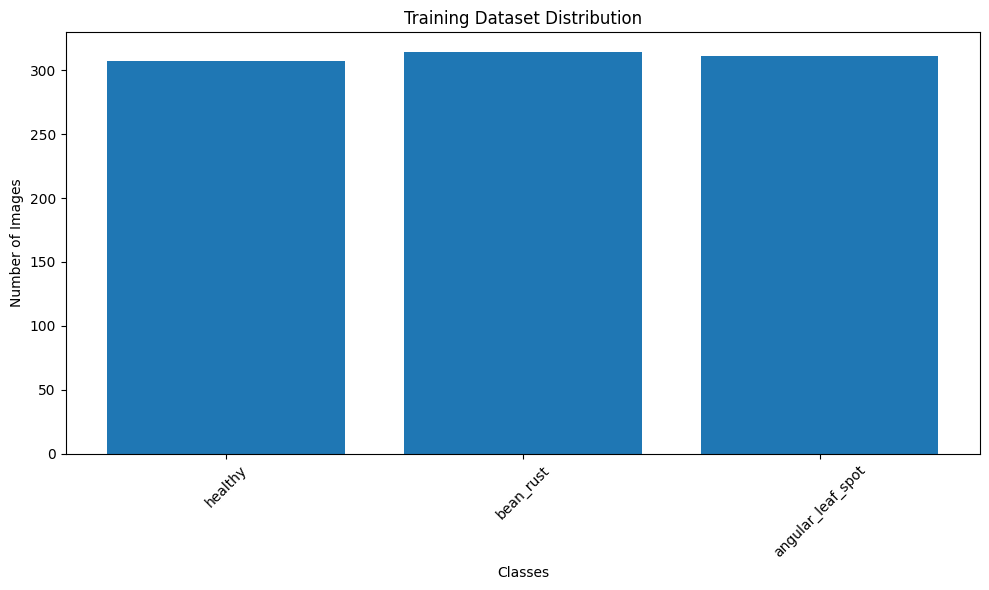

Distribusi dataset untuk testing: {'healthy': 44, 'bean_rust': 45, 'angular_leaf_spot': 44}


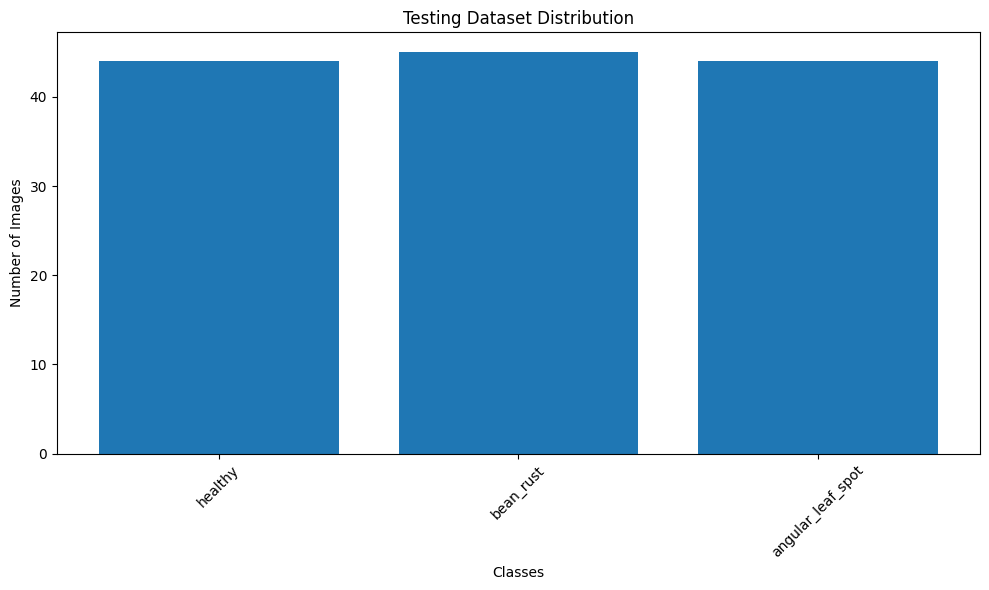

In [8]:
def count_images_in_classes(folder_path):
    """Menghitung jumlah gambar dalam setiap kelas di folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):  # Pastikan hanya menghitung folder (kelas)
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Menampilkan distribusi dataset menggunakan grafik batang."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung distribusi kelas untuk training
training_class_counts = count_images_in_classes(training_path)
print(f"Distribusi dataset untuk training: {training_class_counts}")
plot_distribution(training_class_counts, "Training Dataset Distribution")

# Hitung distribusi kelas untuk testing
testing_class_counts = count_images_in_classes(testing_path)
print(f"Distribusi dataset untuk testing: {testing_class_counts}")
plot_distribution(testing_class_counts, "Testing Dataset Distribution")

## Preview datasets

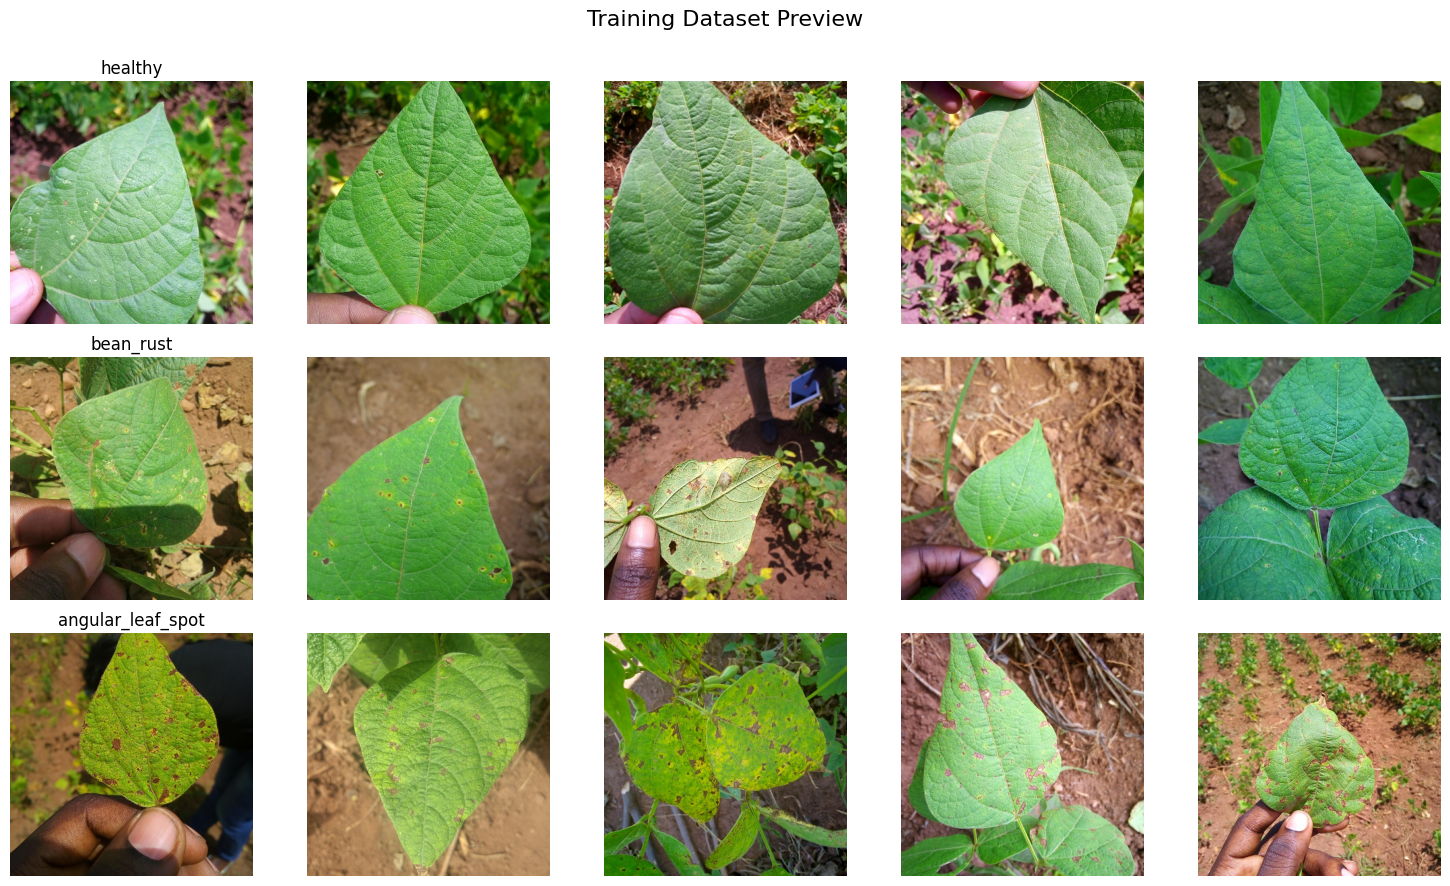

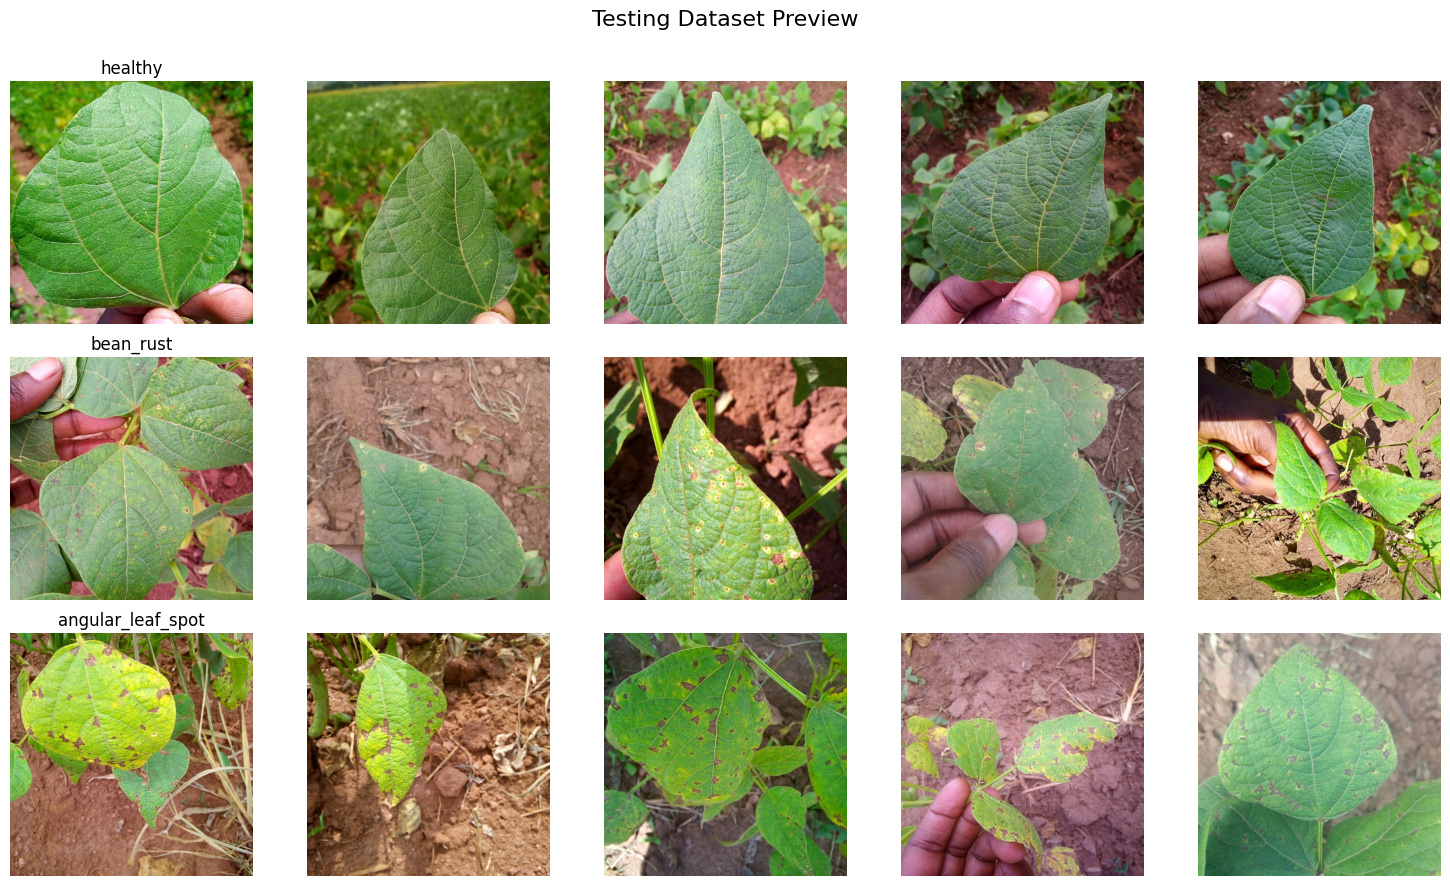

In [9]:
def preview_images(folder_path, title, samples_per_class=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    # Setup grid untuk menampilkan gambar
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        sample_images = images[:samples_per_class]  # Ambil sejumlah gambar untuk preview

        for j in range(samples_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Jika hanya 1 kelas, axes menjadi 1D
            ax.axis('off')

            if j < len(sample_images):  # Jika ada gambar yang cukup
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(cls if j == 0 else "")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Preview gambar di folder training
preview_images(training_path, "Training Dataset Preview", samples_per_class=5)

# Preview gambar di folder testing
preview_images(testing_path, "Testing Dataset Preview", samples_per_class=5)

# MobileNetV3

In [10]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return model.count_params()

# Membuat dictionary untuk setiap model dan menghitung jumlah parameternya
list_models = {
    "MobileNetV3Small": MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    "MobileNetV3Large": MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

I0000 00:00:1735011695.441512    6534 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:56:00.0, compute capability: 8.6


Model Parameter Count
0  MobileNetV3Small         939.120
1  MobileNetV3Large       2.996.352

# EfficientNetV2

In [11]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return model.count_params()

# Membuat dictionary untuk setiap model dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2B0": EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False),
    "EfficientNetV2B1": EfficientNetV2B1(input_shape=(240, 240, 3), include_top=False),
    "EfficientNetV2B2": EfficientNetV2B2(input_shape=(260, 260, 3), include_top=False),
    "EfficientNetV2B3": EfficientNetV2B3(input_shape=(300, 300, 3), include_top=False)
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

Model Parameter Count
0  EfficientNetV2B0       5.919.312
1  EfficientNetV2B1       6.931.124
2  EfficientNetV2B2       8.769.374
3  EfficientNetV2B3      12.930.622

# EfficientNetV2 Modifikasi

In [12]:
import pandas as pd

# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return model.count_params()

# Membuat dictionary untuk setiap model dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2B0Modifikasi": EfficientNetV2B0Modifikasi(input_shape=(224, 224, 3), include_top=False, weights=None),
    "EfficientNetV2B1Modifikasi": EfficientNetV2B1Modifikasi(input_shape=(240, 240, 3), include_top=False, weights=None),
    "EfficientNetV2B2Modifikasi": EfficientNetV2B2Modifikasi(input_shape=(260, 260, 3), include_top=False, weights=None),
    "EfficientNetV2B3Modifikasi": EfficientNetV2B3Modifikasi(input_shape=(300, 300, 3), include_top=False, weights=None)
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

Model Parameter Count
0  EfficientNetV2B0Modifikasi       1.277.800
1  EfficientNetV2B1Modifikasi       1.615.620
2  EfficientNetV2B2Modifikasi       1.876.720
3  EfficientNetV2B3Modifikasi       2.622.368

# Training

## Variabel Global

In [13]:
dataset_path = "datasets/"
save_model_path = "results/best_model/"
result_csv_path = "results/csv/"
image_path = "results/images/"

In [14]:
# Dataset directories
train_dir = os.path.join(dataset_path, "training")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "testing")

input_shapes = {
    "MobileNetV3Small": (224, 224),
    "MobileNetV3Large": (224, 224),
    "EfficientNetV2B0": (224, 224),
    "EfficientNetV2B1": (240, 240),
    "EfficientNetV2B2": (260, 260),
    "EfficientNetV2B3": (300, 300),
    "EfficientNetV2B0Modifikasi": (224, 224),
    "EfficientNetV2B1Modifikasi": (240, 240),
    "EfficientNetV2B2Modifikasi": (260, 260),
    "EfficientNetV2B3Modifikasi": (300, 300),
}

# Random seed
random.seed(42)

## Hyperparameter settings

In [24]:
batch_size = 32
epochs_size = 30
optimizer = "Adam"
dropout_rate = 0.2
learning_rate = 0.001
trainable_percentage = 0.3
trainable_percentage_modifikasi = 1

## Split dataset

In [16]:
def count_images_in_folder(folder_path):
    if not os.path.exists(folder_path):
        return 0
    return sum(len(files) for _, _, files in os.walk(folder_path) if files)

# Fungsi untuk melakukan split
def split_training_data(train_dir, val_dir, validation_split=0.1):
    if os.path.exists(val_dir):
        print(f"Folder '{val_dir}' sudah ada. Tidak melakukan split ulang.")
        return

    os.makedirs(val_dir, exist_ok=True)
    
    # Iterasi setiap kelas di folder training
    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue
        
        os.makedirs(class_val_path, exist_ok=True)

        # Ambil semua file gambar di kelas ini
        all_images = [f for f in os.listdir(class_train_path) if os.path.isfile(os.path.join(class_train_path, f))]
        total_images = len(all_images)

        # Pilih 10% gambar secara acak untuk dipindahkan ke validation
        val_size = int(total_images * validation_split)
        val_images = random.sample(all_images, val_size)

        # Pindahkan gambar ke folder validation
        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dest_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dest_path)

# Hitung jumlah gambar sebelum split
print("Sebelum split:")
train_count_before = count_images_in_folder(train_dir)
val_count_before = count_images_in_folder(val_dir)
print(f"  Training: {train_count_before} gambar")
print(f"  Validation: {val_count_before} gambar")

# Lakukan split
split_training_data(train_dir, val_dir, validation_split=0.1)

# Hitung jumlah gambar setelah split
print("\nSetelah split:")
train_count_after = count_images_in_folder(train_dir)
val_count_after = count_images_in_folder(val_dir)
print(f"  Training: {train_count_after} gambar")
print(f"  Validation: {val_count_after} gambar")

Sebelum split:
  Training: 933 gambar
  Validation: 102 gambar
Folder 'datasets/validation' sudah ada. Tidak melakukan split ulang.

Setelah split:
  Training: 933 gambar
  Validation: 102 gambar


## Data augmentation

In [17]:
# Data augmentation and preprocessing mobileNetV3
def augmentation_generator_MBV3(img_height,img_width):
    train_datagen = ImageDataGenerator(
        preprocessing_function=mobilenetv3_preprocess,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(preprocessing_function=mobilenetv3_preprocess)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator,val_generator,test_generator

In [18]:
# Data augmentation and preprocessing efficientNetV2
def augmentation_generator_ENV2(img_height,img_width):
    train_datagen = ImageDataGenerator(
        preprocessing_function=efficientnetv2_preprocess,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator,val_generator,test_generator

## Build model

In [19]:
def load_base_model(model_name, img_height, img_width, trainable_percentage, skema):
    # Dictionary mapping untuk model-model yang didukung
    model_mapping = {
        "MobileNetV3Small": MobileNetV3Small,
        "MobileNetV3Large": MobileNetV3Large,
        "EfficientNetV2B0": EfficientNetV2B0,
        "EfficientNetV2B1": EfficientNetV2B1,
        "EfficientNetV2B2": EfficientNetV2B2,
        "EfficientNetV2B3": EfficientNetV2B3,
        "EfficientNetV2B0Modifikasi": EfficientNetV2B0Modifikasi,
        "EfficientNetV2B1Modifikasi": EfficientNetV2B1Modifikasi,
        "EfficientNetV2B2Modifikasi": EfficientNetV2B2Modifikasi,
        "EfficientNetV2B3Modifikasi": EfficientNetV2B3Modifikasi,
    }
    
    # Validasi model_name
    if model_name not in model_mapping:
        raise ValueError(f"Unsupported model name: {model_name}")
    
    # Inisialisasi model berdasarkan mapping
    if "Modifikasi" in model_name:
        base_model = model_mapping[model_name](input_shape=(img_height, img_width, 3), 
                                               include_top=False, 
                                               weights= None)
    else:
        if skema == "EN Original 100%T None":
                base_model = model_mapping[model_name](input_shape=(img_height, img_width, 3), 
                                               include_top=False, 
                                               weights=None)
    
        else:
                base_model = model_mapping[model_name](input_shape=(img_height, img_width, 3), 
                                               include_top=False, 
                                               weights='imagenet')


    
    # Mengatur layer trainable berdasarkan persentase
    if skema != "EN Original NT imagenet":
        trainable_layers = int(trainable_percentage * len(base_model.layers))
        for layer in base_model.layers[:trainable_layers]:
            layer.trainable = True
        for layer in base_model.layers[trainable_layers:]:
            layer.trainable = False

    # Build model
    model = build_model(base_model, train_generator.num_classes, dropout_rate)
    
    # Compile model
    compile_model(model, learning_rate)
    
    return model


def build_model(base_model, num_classes,dropout_rate):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def compile_model(model, learning_rate):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

def train_model(model, train_generator, val_generator, epochs_size):
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=epochs_size,
        validation_data=val_generator
    )
    duration = time.time() - start_time
    return history, duration

def evaluate_model(model, test_generator):
    eval_result = model.evaluate(test_generator)
    return eval_result[1] * 100, eval_result[0]

def save_model(model, save_path, timestamp, model_name):
    model_save_path = os.path.join(save_path, f"{model_name}_{timestamp}.keras")
    model.save(model_save_path)
    return model_save_path

def save_results_to_csv(results, csv_save_path):
    df = pd.DataFrame(results)
    if os.path.exists(csv_save_path):
        existing_df = pd.read_csv(csv_save_path)
        df = pd.concat([existing_df, df], ignore_index=True)
    df.to_csv(csv_save_path, index=False)

def plot_training_metrics(history, image_path, timestamp):
    # Accuracy Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig(os.path.join(image_path, f"training_accuracy_{timestamp}.png"))
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(os.path.join(image_path, f"training_loss_{timestamp}.png"))
    plt.show()

def plot_confusion_matrix(model, test_generator, image_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(test_generator.class_indices)))

    fig, ax = plt.subplots(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)

    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    confusion_matrix_path = os.path.join(image_path, f"confusion_matrix_{timestamp}.png")
    fig.savefig(confusion_matrix_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)
    return confusion_matrix_path

def run_training(model):
    # Send training start message
    send_training_start_message(model_name, (img_height, img_width), batch_size, epochs_size)
    
    # Train model
    history, training_duration = train_model(model, train_generator, val_generator, epochs_size)
    
    # Evaluate model
    test_accuracy, test_loss = evaluate_model(model, test_generator)
    
    # Save model
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    save_model(model, save_model_path, timestamp,model_name)
    
    # Save results
    results = {
        "Timestamp": [timestamp],
        "Model": [model_name],
        "Skema":[skema],
        "Batch Size": [batch_size],
        "Epochs": [epochs_size],
        "Training Accuracy": [max(history.history['accuracy']) * 100],
        "Validation Accuracy": [max(history.history['val_accuracy']) * 100],
        "Testing Accuracy": [test_accuracy],
        "Training Loss": [min(history.history['loss'])],
        "Validation Loss": [min(history.history['val_loss'])],
        "Testing Loss": [test_loss],
        "Training Duration (seconds)": [training_duration],
        "Training Duration (minutes)": [f"{training_duration / 60:.2f}"],
        "Trainable Percentage": [trainable_percentage_modifikasi * 100 if "Modifikasi" in model_name else trainable_percentage * 100],
        "Total Parameter": [f"{model.count_params():,}".replace(",", ".")]
    }
    save_results_to_csv(results, os.path.join(result_csv_path, "training_results_runpod.csv"))

    show_classification_report(model, test_generator, result_csv_path, timestamp)

    return history, image_path, timestamp, model, training_duration, test_accuracy

def plot_history(history, image_path, timestamp, model, training_duration, test_accuracy):
    # Plot metrics
    plot_training_metrics(history, image_path, timestamp)
    
    # Plot confusion matrix
    confusion_matrix_path = plot_confusion_matrix(model, test_generator, image_path, timestamp)
    
    # Send training end message
    send_training_end_message(
        model_name,
        total_duration=f"{training_duration / 60:.2f} minutes",
        training_accuracy=(history.history['accuracy'][-1])* 100,
        validation_accuracy=(history.history['val_accuracy'][-1])* 100,
        testing_accuracy=test_accuracy,
        total_parameters=f"{model.count_params():,}".replace(",", ".")
    )
    
    send_telegram_message("Confusion Matrix", confusion_matrix_path)

def show_classification_report(model, test_generator, save_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    class_labels = list(test_generator.class_indices.keys())

    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

## Train Model

### MobileNet

#### MobileNetV3Small

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1735011714.805135    6873 service.cc:148] XLA service 0x796268003180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735011714.805231    6873 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-12-24 03:41:55.058607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735011716.187477    6873 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 03:41:56.853098: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-12-24 03:41:59.921399: I e

 1/30 ━━━━━━━━━━━━━━━━━━━━ 11:16 23s/step - accuracy: 0.2812 - loss: 1.5421

I0000 00:00:1735011730.398492    6873 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-24 03:42:14.305149: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7981', 268 bytes spill stores, 300 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4341 - loss: 1.1701

2024-12-24 03:42:50.845727: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1340', 268 bytes spill stores, 300 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4381 - loss: 1.1626 - val_accuracy: 0.8529 - val_loss: 0.5304
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 689ms/step - accuracy: 0.7666 - loss: 0.5598 - val_accuracy: 0.8137 - val_loss: 0.4874
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 481ms/step - accuracy: 0.7871 - loss: 0.4934 - val_accuracy: 0.7745 - val_loss: 0.5405
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.8187 - loss: 0.4045 - val_accuracy: 0.6961 - val_loss: 0.6943
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - accuracy: 0.8556 - loss: 0.3589 - val_accuracy: 0.7353 - val_loss: 0.7253
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step - accuracy: 0.8818 - loss: 0.3193 - val_accuracy: 0.6765 - val_loss: 0.8804
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 532ms/step - accuracy: 0.8940 - loss: 0.2680 - val_accuracy: 0.7549 - val_loss: 0.5687
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 507ms/step - accuracy: 0.8984 - loss: 0.2831 - val_accuracy: 0.7255 -

2024-12-24 03:55:33.405116: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1340', 268 bytes spill stores, 300 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7879 - loss: 0.8259  
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       0.69      1.00      0.81        44
        bean_rust       1.00      0.31      0.47        45
          healthy       0.78      0.98      0.87        44

         accuracy                           0.76       133
        macro avg       0.82      0.76      0.72       133
     weighted avg       0.82      0.76      0.72       133



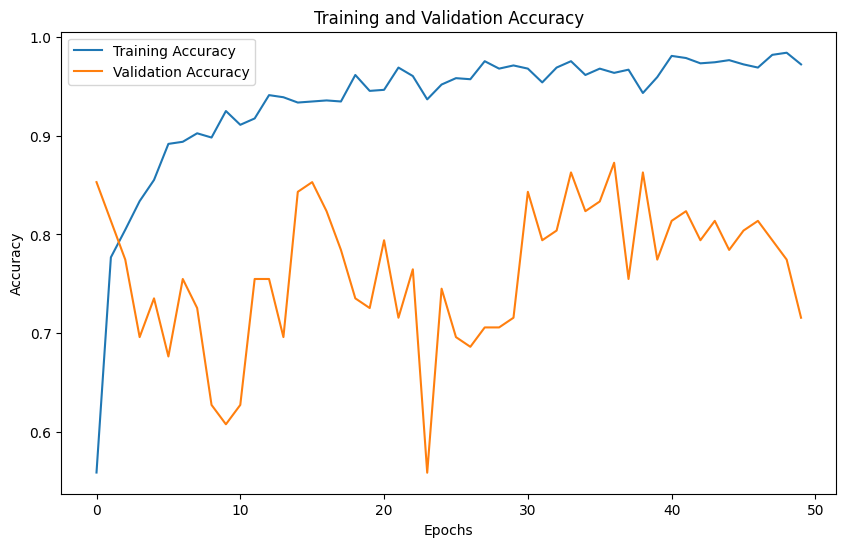

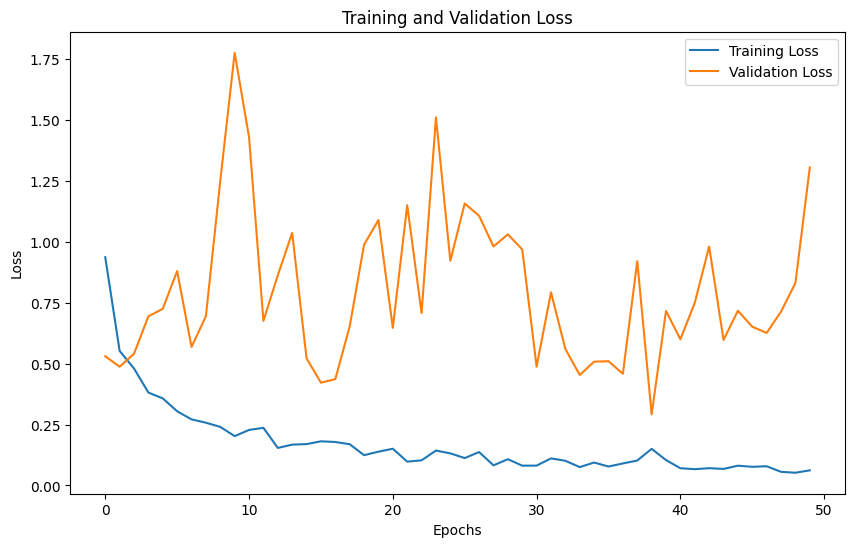

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step


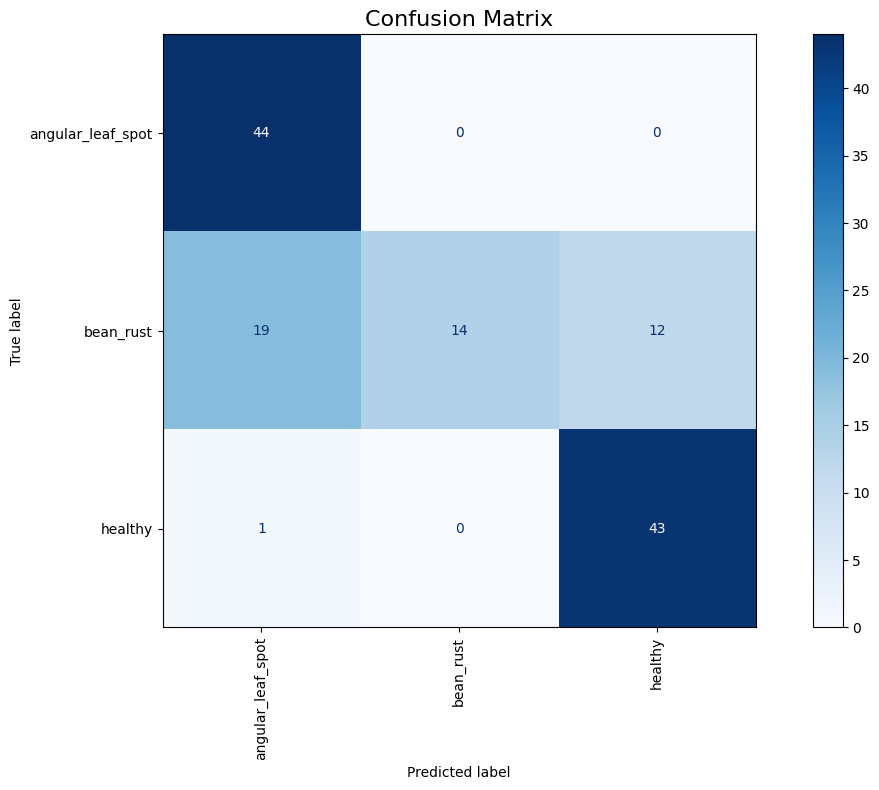

In [20]:
model_name = "MobileNetV3Small"
skema = "MobileNet"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_MBV3(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### MobileNetV3Large

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2024-12-24 03:56:11.435305: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9415', 16 bytes spill stores, 16 bytes spill loads

2024-12-24 03:56:11.750359: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12789', 8 bytes spill stores, 8 bytes spill loads

2024-12-24 03:56:11.769414: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12789', 24 bytes spill stores, 24 bytes spill loads

2024-12-24 03:56:11.786929: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12789', 8 bytes spill stores, 8 bytes spill loads

2024-12-24 03:56:11.792976: I external/local_xla/xla/stream_e

21/30 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - accuracy: 0.5124 - loss: 1.0640

2024-12-24 03:56:37.068989: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9415', 268 bytes spill stores, 300 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.5409 - loss: 0.9964

2024-12-24 03:56:57.959125: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1555', 268 bytes spill stores, 300 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5440 - loss: 0.9898 - val_accuracy: 0.8627 - val_loss: 0.3753
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 493ms/step - accuracy: 0.8088 - loss: 0.4636 - val_accuracy: 0.9020 - val_loss: 0.2096
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 490ms/step - accuracy: 0.8900 - loss: 0.2896 - val_accuracy: 0.9118 - val_loss: 0.2394
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 475ms/step - accuracy: 0.9086 - loss: 0.2366 - val_accuracy: 0.9216 - val_loss: 0.1448
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 525ms/step - accuracy: 0.9167 - loss: 0.1769 - val_accuracy: 0.8922 - val_loss: 0.2608
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 536ms/step - accuracy: 0.9059 - loss: 0.2347 - val_accuracy: 0.9118 - val_loss: 0.2204
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 482ms/step - accuracy: 0.9307 - loss: 0.2161 - val_accuracy: 0.9314 - val_loss: 0.1819
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 446ms/step - accuracy: 0.9330 - loss: 0.1801 - val_accuracy: 0.9020 -

2024-12-24 04:10:24.568912: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1555', 268 bytes spill stores, 300 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9919 - loss: 0.0120  
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       1.00      0.98      0.99        44
        bean_rust       0.98      1.00      0.99        45
          healthy       1.00      1.00      1.00        44

         accuracy                           0.99       133
        macro avg       0.99      0.99      0.99       133
     weighted avg       0.99      0.99      0.99       133



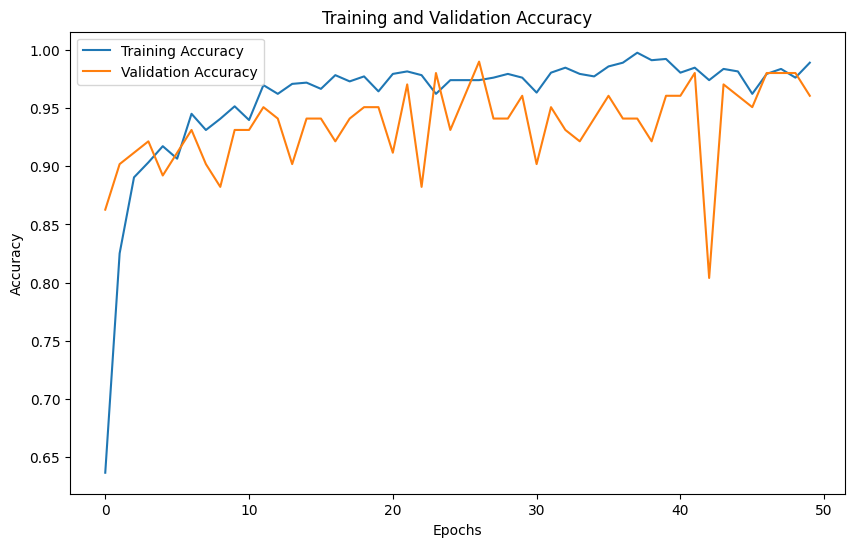

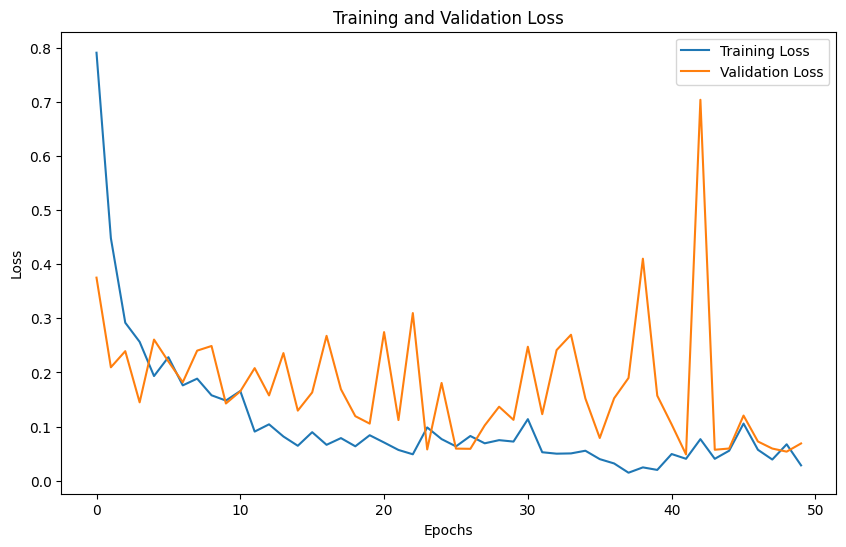

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step


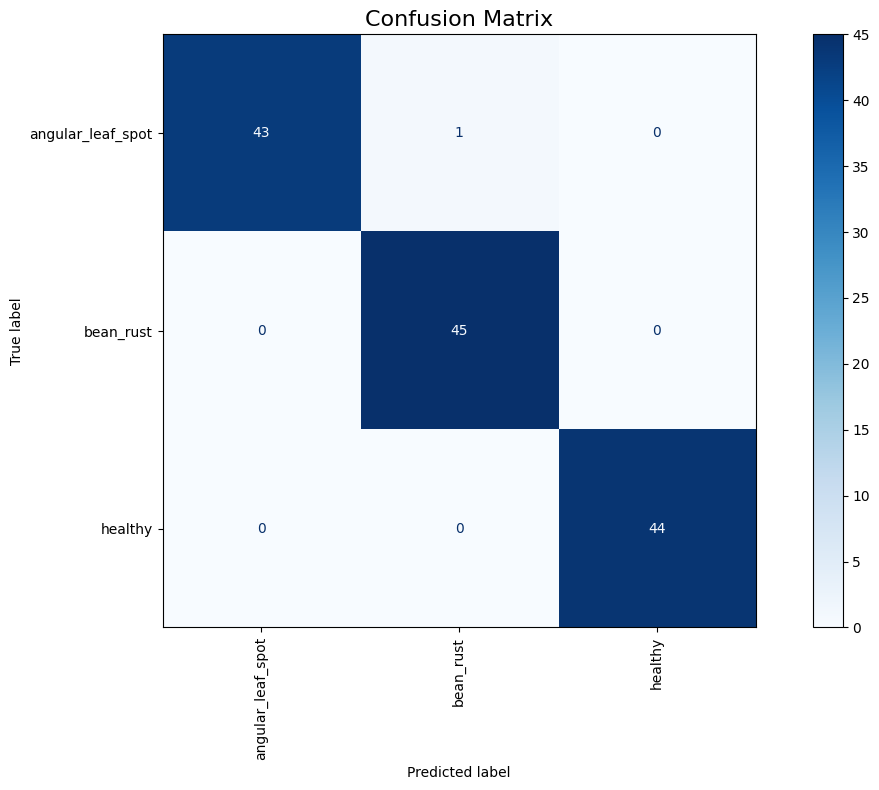

In [21]:
model_name = "MobileNetV3Large"
skema = "MobileNet"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_MBV3(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EN Original NT imagenet

In [25]:
bath_size = 32
trainable_percentage = 0

#### EfficientNetV2B0

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2024-12-24 04:12:20.327292: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24324', 16 bytes spill stores, 16 bytes spill loads

2024-12-24 04:12:20.831171: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24638', 24 bytes spill stores, 24 bytes spill loads

2024-12-24 04:12:20.835673: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24324_0', 112 bytes spill stores, 144 bytes spill loads

2024-12-24 04:12:20.840163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24638', 60 bytes spill stores, 64 bytes spill loads

2024-12-24 04:12:20.896690: I external/local_xla/xla

30/30 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6119 - loss: 0.8048 - val_accuracy: 0.9314 - val_loss: 0.2147
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 577ms/step - accuracy: 0.8990 - loss: 0.2891 - val_accuracy: 0.9118 - val_loss: 0.4260
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 513ms/step - accuracy: 0.9260 - loss: 0.2089 - val_accuracy: 0.9314 - val_loss: 0.1457
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 536ms/step - accuracy: 0.9486 - loss: 0.1600 - val_accuracy: 0.9510 - val_loss: 0.2046
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 567ms/step - accuracy: 0.9111 - loss: 0.2254 - val_accuracy: 0.9902 - val_loss: 0.0788
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 533ms/step - accuracy: 0.9354 - loss: 0.2005 - val_accuracy: 0.9706 - val_loss: 0.0682
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 548ms/step - accuracy: 0.9572 - loss: 0.1328 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 536ms/step - accuracy: 0.9527 - loss: 0.1467 - val_accuracy: 0.9804 

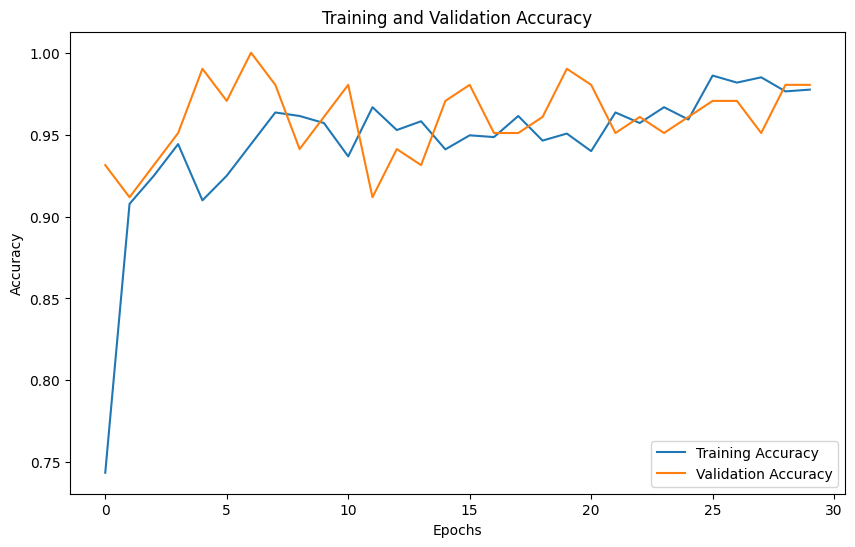

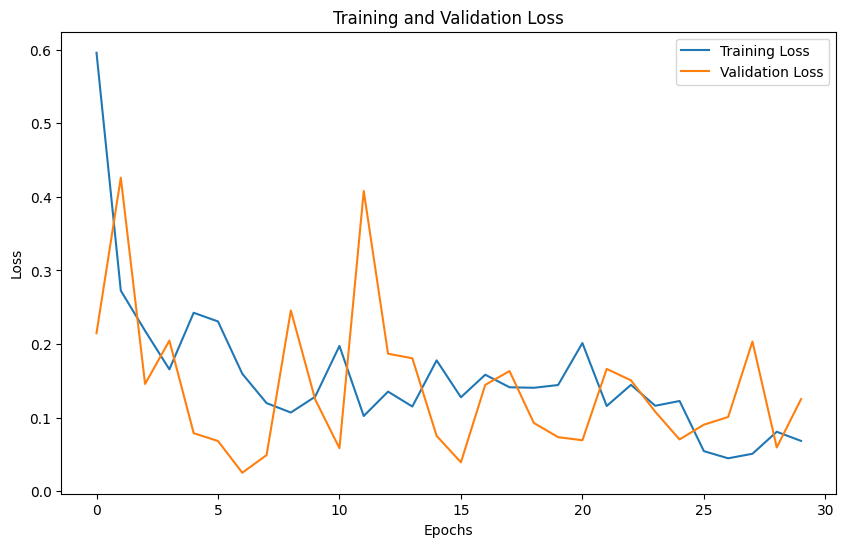

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


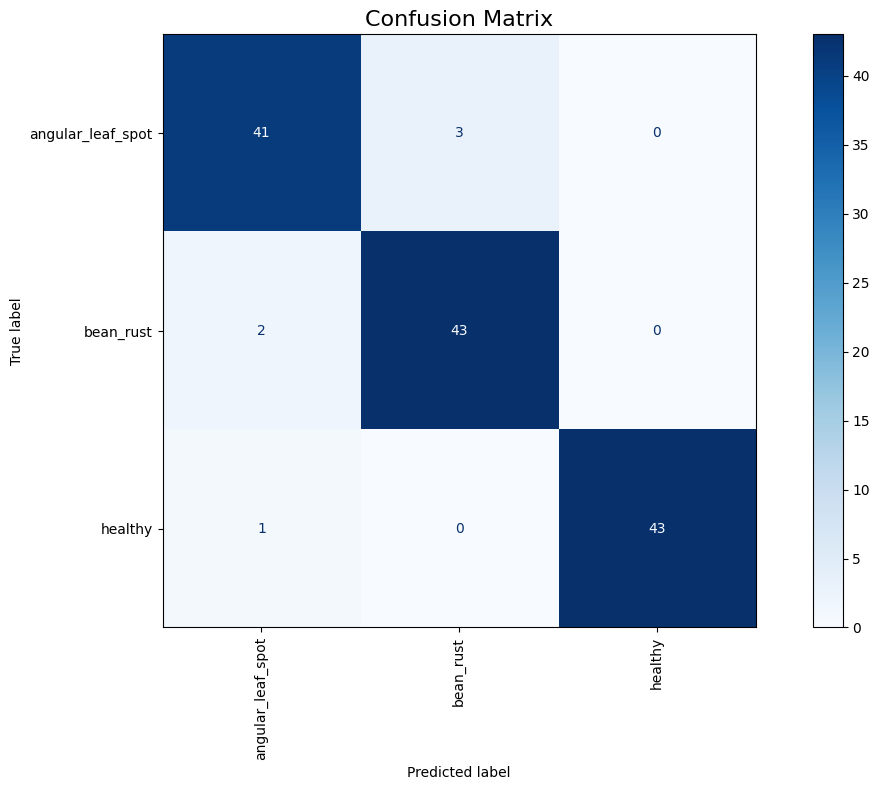

In [26]:
model_name = "EfficientNetV2B0"
skema = "EN Original NT imagenet"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B1

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6393 - loss: 0.7804 - val_accuracy: 0.7941 - val_loss: 0.8443
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 596ms/step - accuracy: 0.8766 - loss: 0.3038 - val_accuracy: 0.8431 - val_loss: 0.9277
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 596ms/step - accuracy: 0.9073 - loss: 0.2773 - val_accuracy: 0.8333 - val_loss: 0.6751
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 594ms/step - accuracy: 0.9392 - loss: 0.1953 - val_accuracy: 0.9706 - val_loss: 0.1070
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 597ms/step - accuracy: 0.9399 - loss: 0.1836 - val_accuracy: 0.9216 - val_loss: 0.3412
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 554ms/step - accuracy: 0.9066 - loss: 0.2722 - val_accuracy: 0.9314 - val_loss: 0.1709
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 584ms/step - accuracy: 0.9654 - loss: 0.1298 - val_accuracy: 0.9902 - val_loss: 0.0478
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 591ms/step - accuracy: 0.9558 - loss: 0.1310 - val_accura

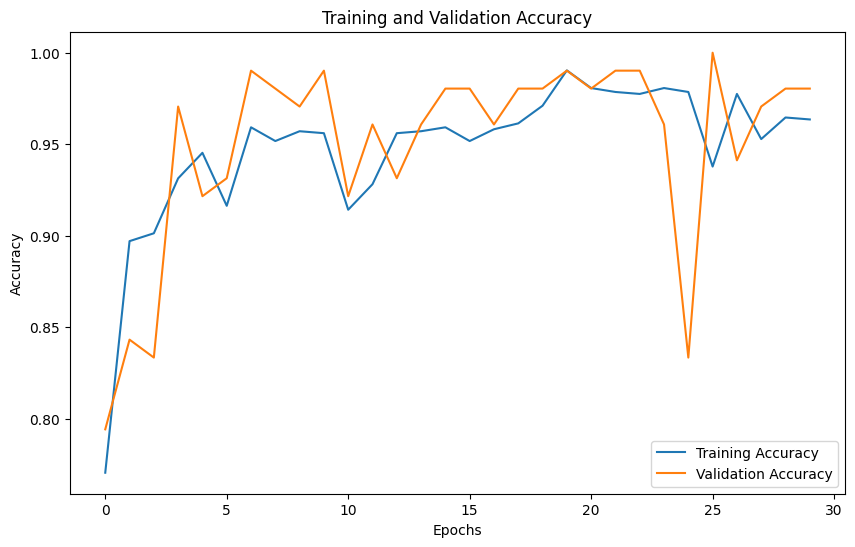

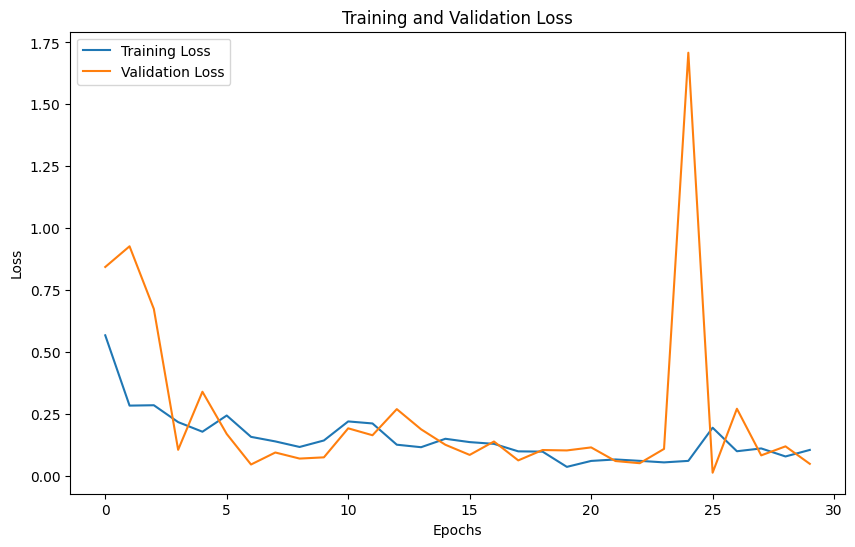

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step


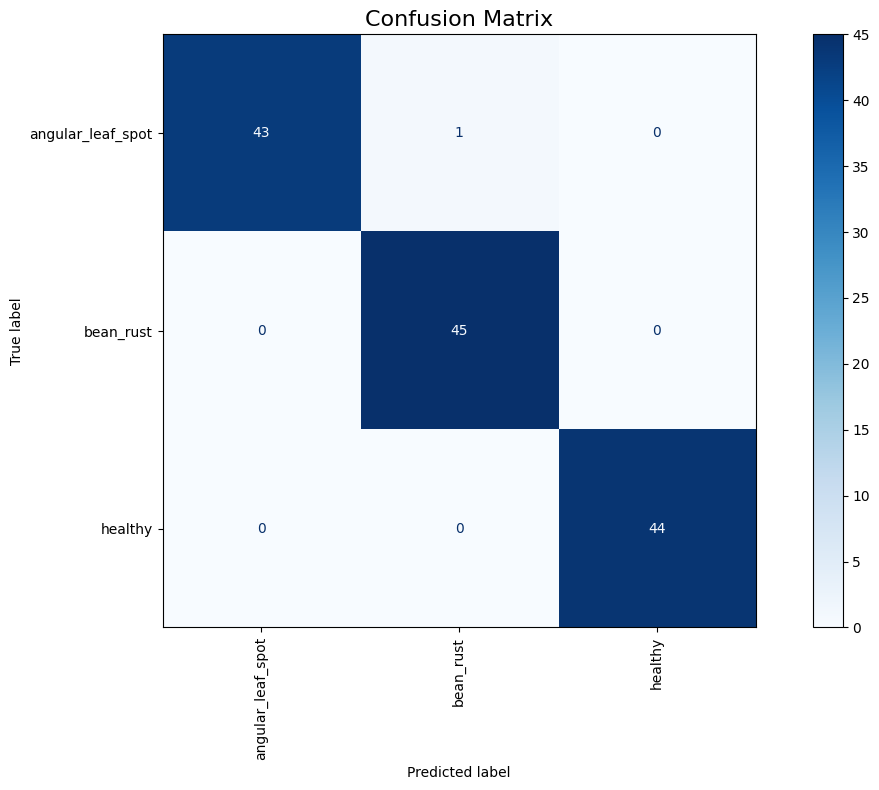

In [27]:
model_name = "EfficientNetV2B1"
skema = "EN Original NT imagenet"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B2

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2024-12-24 04:35:20.360889: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31947', 16 bytes spill stores, 16 bytes spill loads

2024-12-24 04:35:20.440104: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32261', 60 bytes spill stores, 64 bytes spill loads

2024-12-24 04:35:20.521906: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32261', 68 bytes spill stores, 72 bytes spill loads

2024-12-24 04:35:20.523552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32261', 24 bytes spill stores, 24 bytes spill loads

2024-12-24 04:35:20.531951: I external/local_xla/xla/str

30/30 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.6452 - loss: 0.7289 - val_accuracy: 0.9510 - val_loss: 0.2172
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 685ms/step - accuracy: 0.9000 - loss: 0.3188 - val_accuracy: 0.9706 - val_loss: 0.0836
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 911ms/step - accuracy: 0.9207 - loss: 0.2683 - val_accuracy: 0.9804 - val_loss: 0.0612
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 631ms/step - accuracy: 0.9203 - loss: 0.2072 - val_accuracy: 0.9510 - val_loss: 0.1986
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 613ms/step - accuracy: 0.9434 - loss: 0.1609 - val_accuracy: 0.9118 - val_loss: 0.1783
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - accuracy: 0.9469 - loss: 0.1684 - val_accuracy: 0.9706 - val_loss: 0.1727
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 627ms/step - accuracy: 0.8978 - loss: 0.2794 - val_accuracy: 0.9608 - val_loss: 0.1827
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 611ms/step - accuracy: 0.9523 - loss: 0.1467 - val_accuracy: 0.9216 

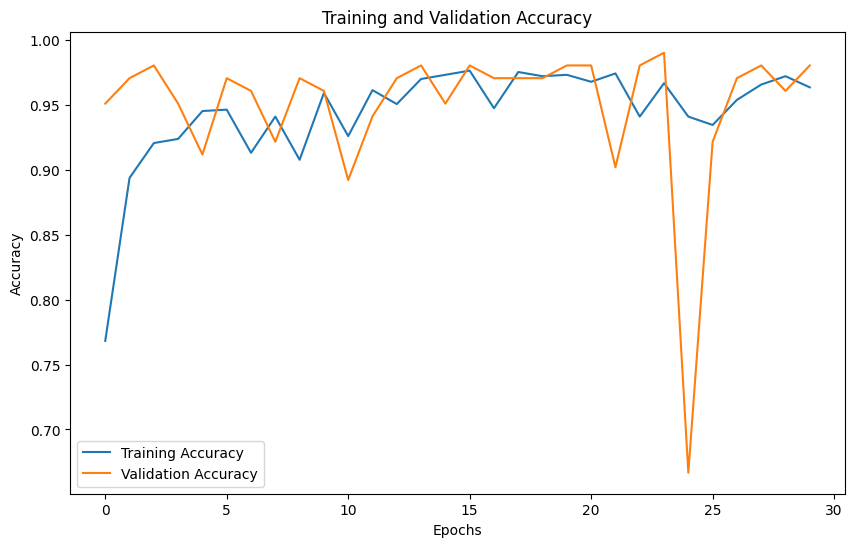

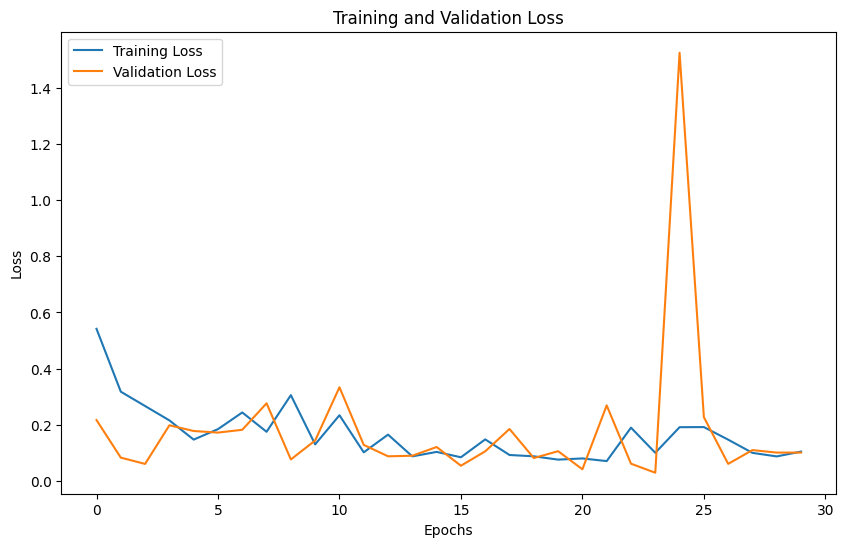

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


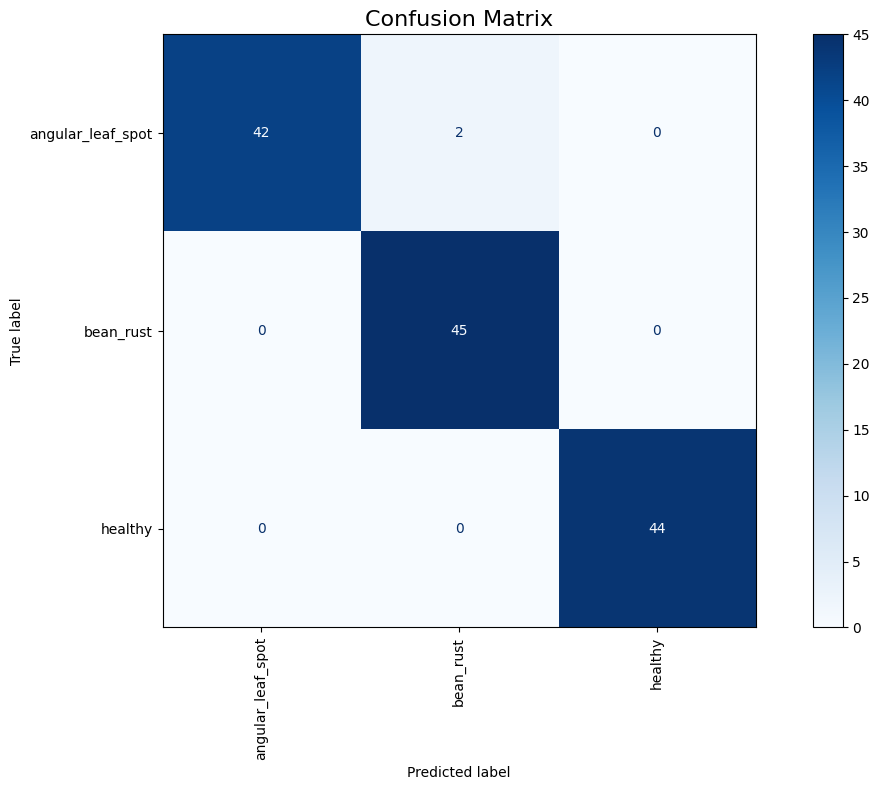

In [28]:
model_name = "EfficientNetV2B2"
skema = "EN Original NT imagenet"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B3

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2024-12-24 04:48:21.843069: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37171', 16 bytes spill stores, 16 bytes spill loads

2024-12-24 04:48:22.409085: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37485', 24 bytes spill stores, 24 bytes spill loads

2024-12-24 04:48:22.409365: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37171_0', 112 bytes spill stores, 168 bytes spill loads

2024-12-24 04:48:22.437369: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37485', 68 bytes spill stores, 72 bytes spill loads

2024-12-24 04:48:22.449923: I external/local_xla/xla

 6/30 ━━━━━━━━━━━━━━━━━━━━ 15s 626ms/step - accuracy: 0.5314 - loss: 0.9989

2024-12-24 04:49:19.654757: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37171_0', 8 bytes spill stores, 8 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6798 - loss: 0.7537

2024-12-24 04:50:27.234520: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3423_0', 8 bytes spill stores, 8 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.6831 - loss: 0.7478 - val_accuracy: 0.9314 - val_loss: 0.1776
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 909ms/step - accuracy: 0.9125 - loss: 0.2945 - val_accuracy: 0.8824 - val_loss: 0.4075
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 735ms/step - accuracy: 0.9286 - loss: 0.1980 - val_accuracy: 0.9804 - val_loss: 0.0693
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 707ms/step - accuracy: 0.9446 - loss: 0.1731 - val_accuracy: 0.9118 - val_loss: 0.2726
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.9293 - loss: 0.2309 - val_accuracy: 0.9412 - val_loss: 0.2140
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 783ms/step - accuracy: 0.9198 - loss: 0.2652 - val_accuracy: 0.9804 - val_loss: 0.1040
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 778ms/step - accuracy: 0.9299 - loss: 0.2089 - val_accuracy: 0.9706 - val_loss: 0.1356
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 764ms/step - accuracy: 0.9583 - loss: 0.0939 - val_accuracy: 0.9706 

2024-12-24 05:01:40.572420: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3423_0', 8 bytes spill stores, 8 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9733 - loss: 0.0693  
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step 
Classification Report:
                    precision    recall  f1-score   support

angular_leaf_spot       1.00      0.95      0.98        44
        bean_rust       0.96      1.00      0.98        45
          healthy       1.00      1.00      1.00        44

         accuracy                           0.98       133
        macro avg       0.99      0.98      0.99       133
     weighted avg       0.99      0.98      0.98       133



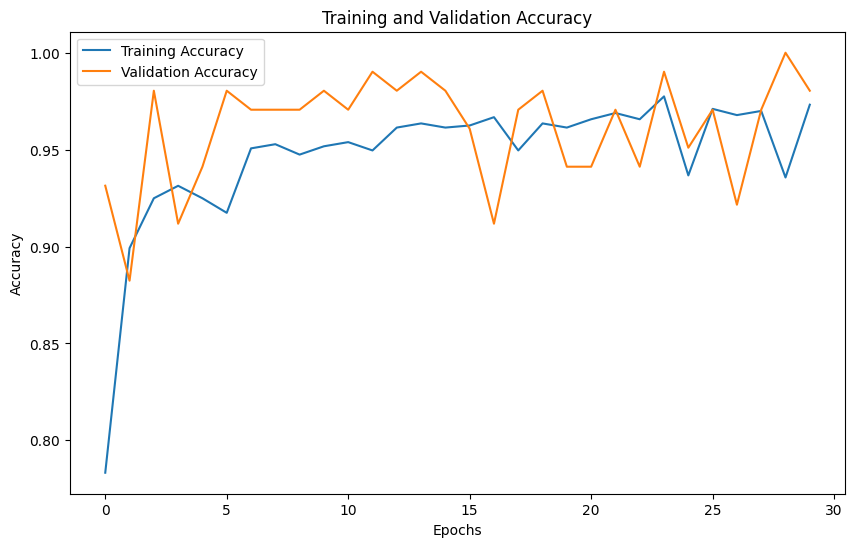

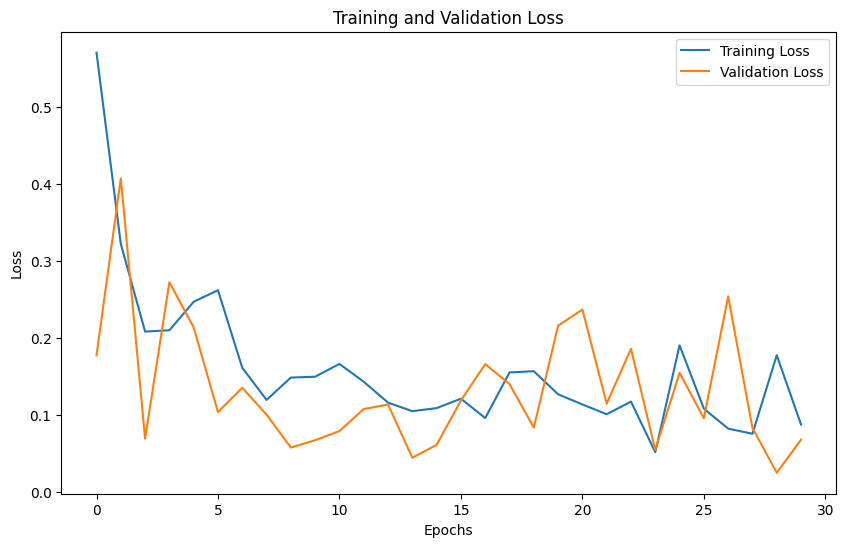

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step


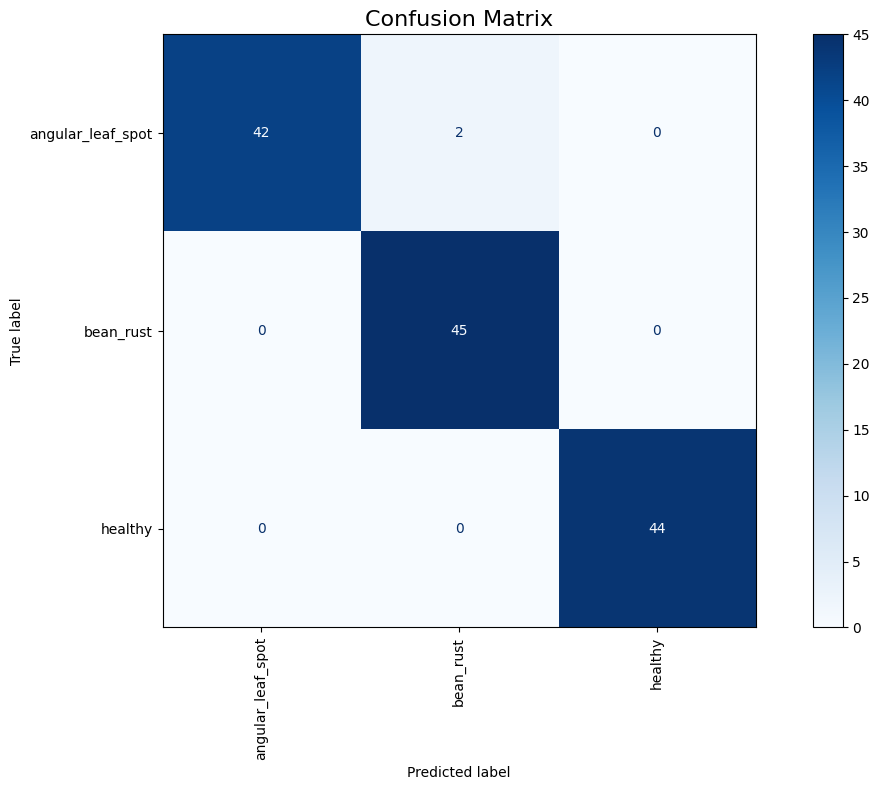

In [29]:
model_name = "EfficientNetV2B3"
skema = "EN Original NT imagenet"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EN Original 30%T imagenet

In [30]:
trainable_percentage = 0.3
batch_size = 32

#### EfficientNetV2B0

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5445 - loss: 0.9024 - val_accuracy: 0.9118 - val_loss: 0.2194
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8727 - loss: 0.3419 - val_accuracy: 0.9412 - val_loss: 0.1749
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 719ms/step - accuracy: 0.8830 - loss: 0.3120 - val_accuracy: 0.9510 - val_loss: 0.1398
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 548ms/step - accuracy: 0.9496 - loss: 0.1714 - val_accuracy: 0.9902 - val_loss: 0.0552
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 568ms/step - accuracy: 0.9592 - loss: 0.1283 - val_accuracy: 0.9608 - val_loss: 0.1147
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 587ms/step - accuracy: 0.9715 - loss: 0.0876 - val_accuracy: 0.9804 - val_loss: 0.0957
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 548ms/step - accuracy: 0.9503 - loss: 0.1351 - val_accuracy: 0.9804 - val_loss: 0.0569
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 587ms/step - accuracy: 0.9415 - loss: 0.1586 - val_accuracy: 

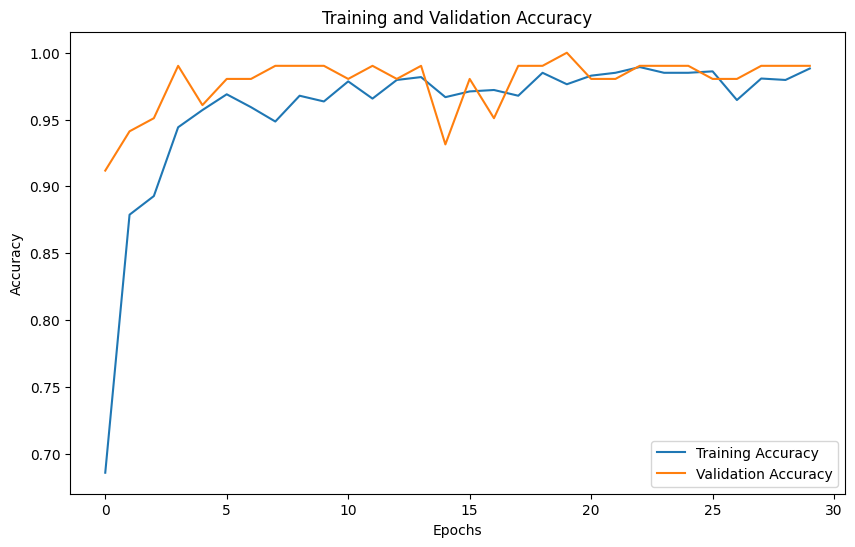

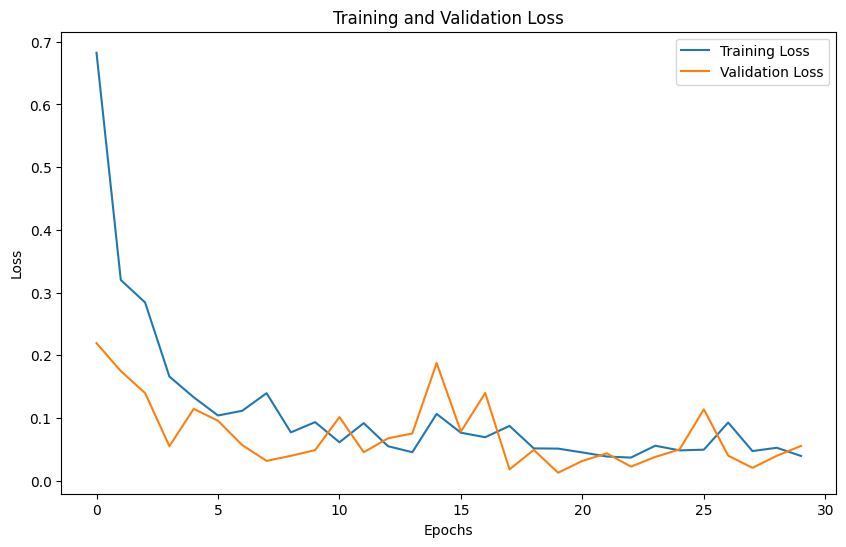

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


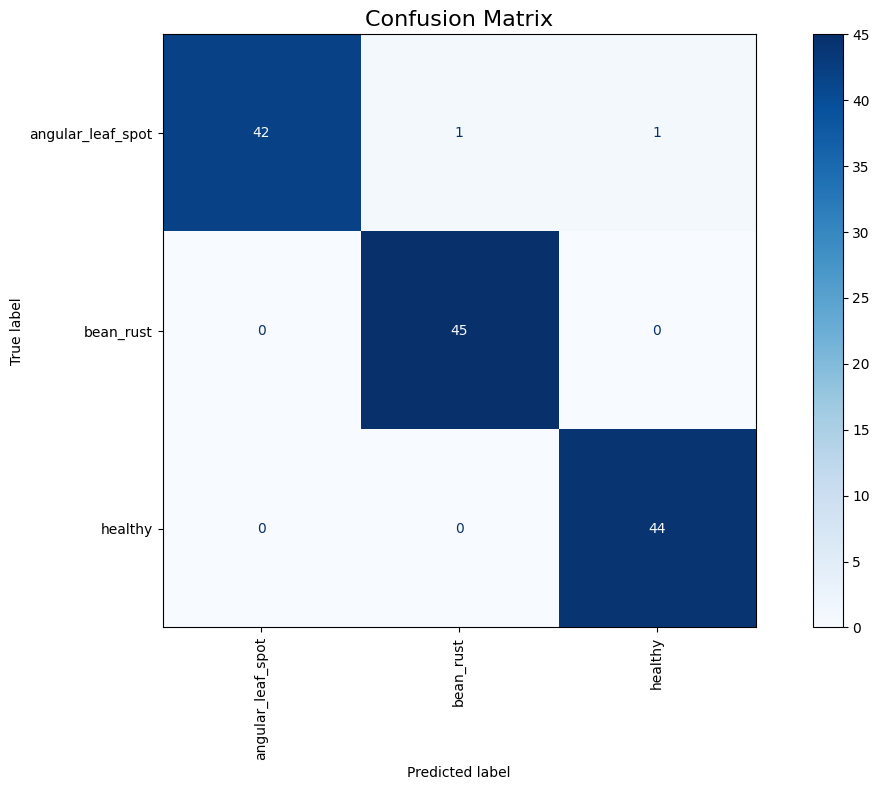

In [31]:
model_name = "EfficientNetV2B0"
skema = "EN Original 30%T imagenet"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B1

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5700 - loss: 0.8748 - val_accuracy: 0.8627 - val_loss: 0.3497
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 628ms/step - accuracy: 0.7978 - loss: 0.4563 - val_accuracy: 0.9118 - val_loss: 0.1890
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 643ms/step - accuracy: 0.9193 - loss: 0.2445 - val_accuracy: 0.9314 - val_loss: 0.2209
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 584ms/step - accuracy: 0.9485 - loss: 0.1568 - val_accuracy: 0.9706 - val_loss: 0.1179
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 577ms/step - accuracy: 0.9582 - loss: 0.1243 - val_accuracy: 0.9608 - val_loss: 0.1241
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 535ms/step - accuracy: 0.9642 - loss: 0.1169 - val_accuracy: 0.9510 - val_loss: 0.1102
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - accuracy: 0.9286 - loss: 0.1891 - val_accuracy: 0.9608 - val_loss: 0.1307
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 505ms/step - accuracy: 0.9693 - loss: 0.1032 - val_accurac

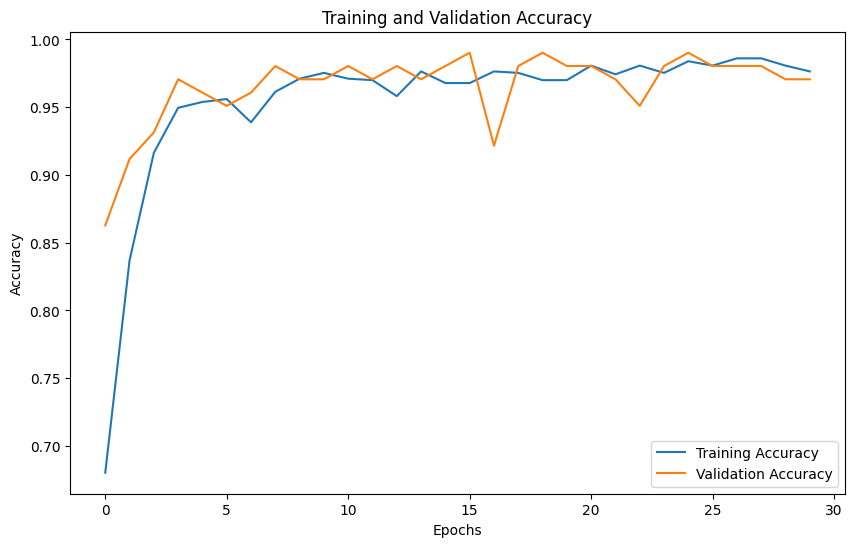

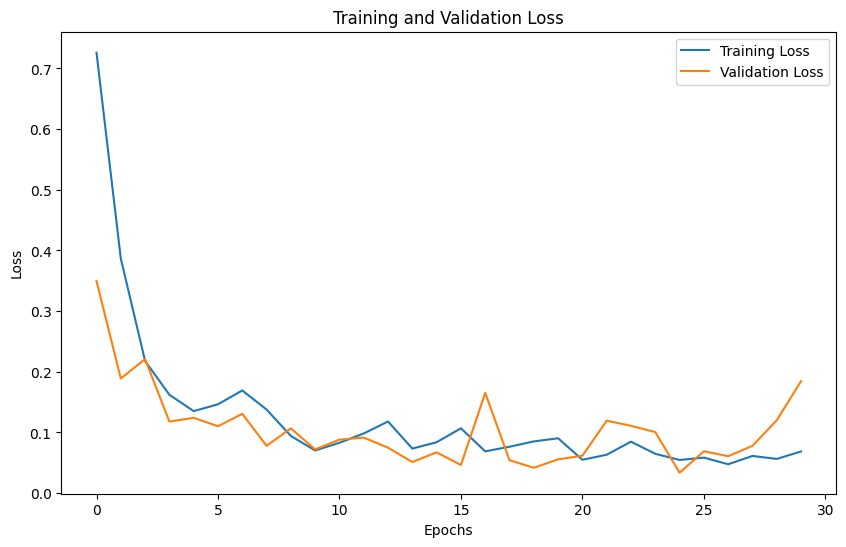

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


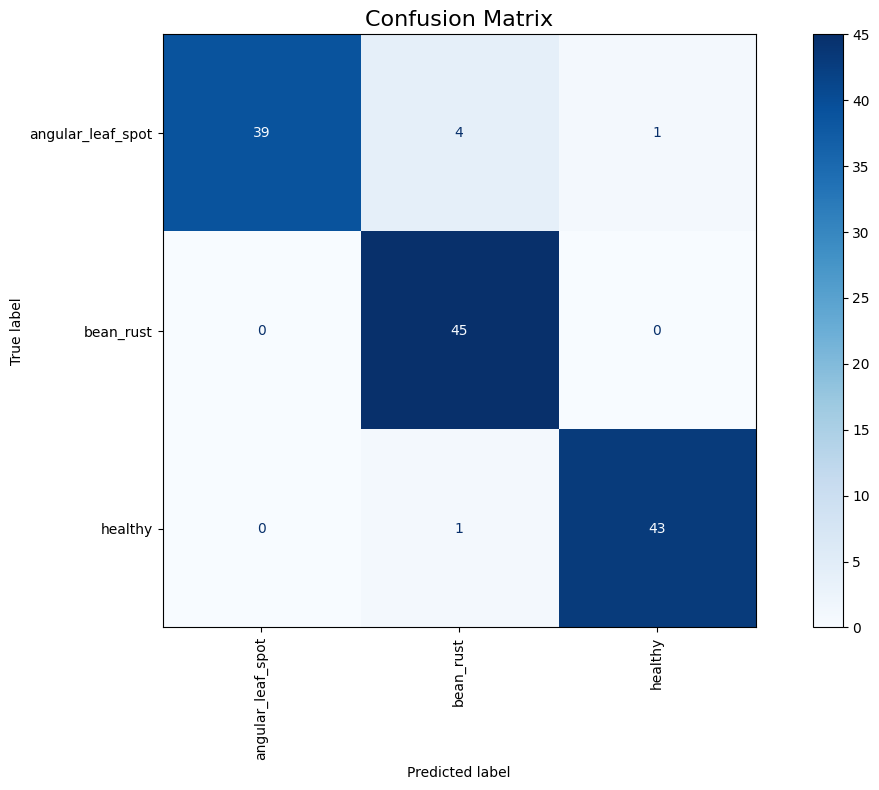

In [32]:
model_name = "EfficientNetV2B1"
skema = "EN Original 30%T imagenet"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B2

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5647 - loss: 0.8867 - val_accuracy: 0.8529 - val_loss: 0.3620
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 641ms/step - accuracy: 0.8431 - loss: 0.3920 - val_accuracy: 0.9216 - val_loss: 0.1896
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 634ms/step - accuracy: 0.9240 - loss: 0.2097 - val_accuracy: 0.9608 - val_loss: 0.1009
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 686ms/step - accuracy: 0.9481 - loss: 0.1252 - val_accuracy: 0.9608 - val_loss: 0.0647
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 671ms/step - accuracy: 0.9681 - loss: 0.0905 - val_accuracy: 0.9608 - val_loss: 0.1203
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 675ms/step - accuracy: 0.9380 - loss: 0.1480 - val_accuracy: 0.9510 - val_loss: 0.1327
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 728ms/step - accuracy: 0.9602 - loss: 0.1251 - val_accuracy: 0.9804 - val_loss: 0.0543
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9352 - loss: 0.1502 - val_accurac

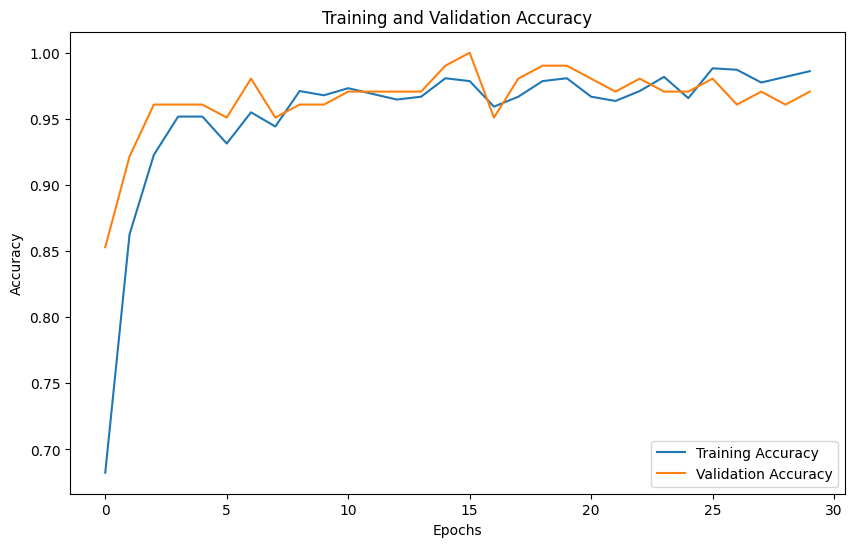

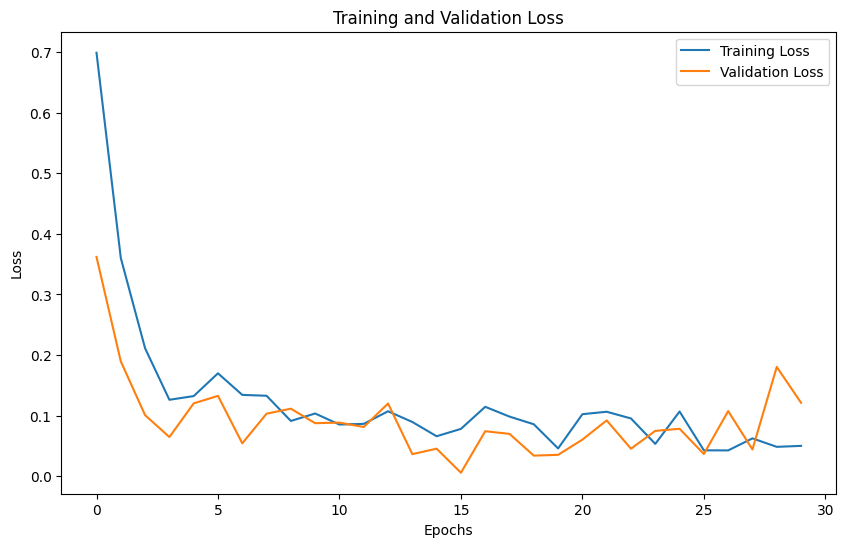

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


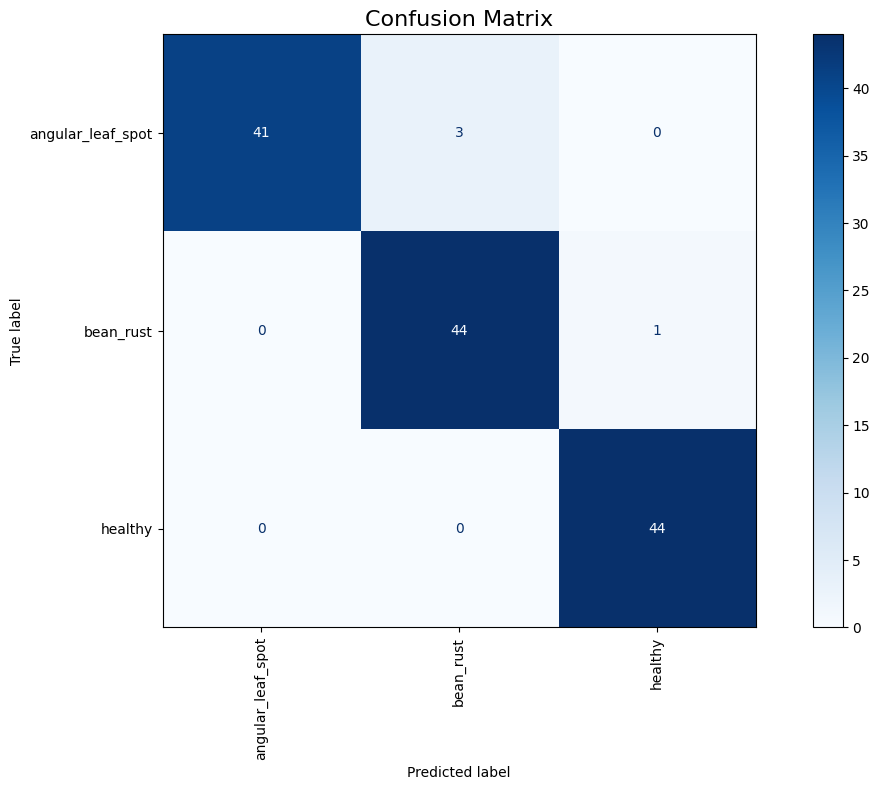

In [33]:
model_name = "EfficientNetV2B2"
skema = "EN Original 30%T imagenet"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B3

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5689 - loss: 0.9031 - val_accuracy: 0.8725 - val_loss: 0.3313
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 767ms/step - accuracy: 0.8619 - loss: 0.3647 - val_accuracy: 0.9510 - val_loss: 0.1427
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 739ms/step - accuracy: 0.9387 - loss: 0.1730 - val_accuracy: 0.9706 - val_loss: 0.0602
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 759ms/step - accuracy: 0.9617 - loss: 0.1247 - val_accuracy: 0.9804 - val_loss: 0.1322
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 745ms/step - accuracy: 0.9678 - loss: 0.0917 - val_accuracy: 0.8922 - val_loss: 0.3305
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 800ms/step - accuracy: 0.9269 - loss: 0.2665 - val_accuracy: 0.9510 - val_loss: 0.1234
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 885ms/step - accuracy: 0.9766 - loss: 0.0829 - val_accuracy: 0.9216 - val_loss: 0.2444
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 834ms/step - accuracy: 0.9557 - loss: 0.1393 - val_accura

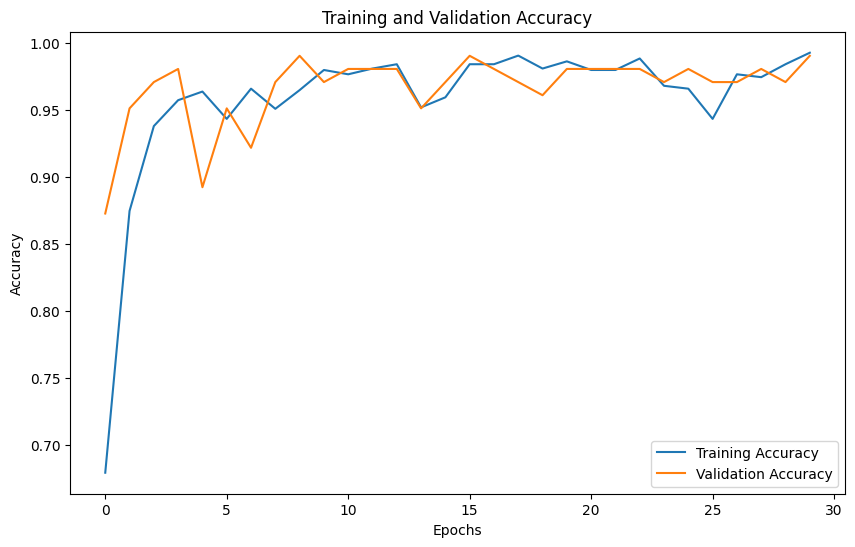

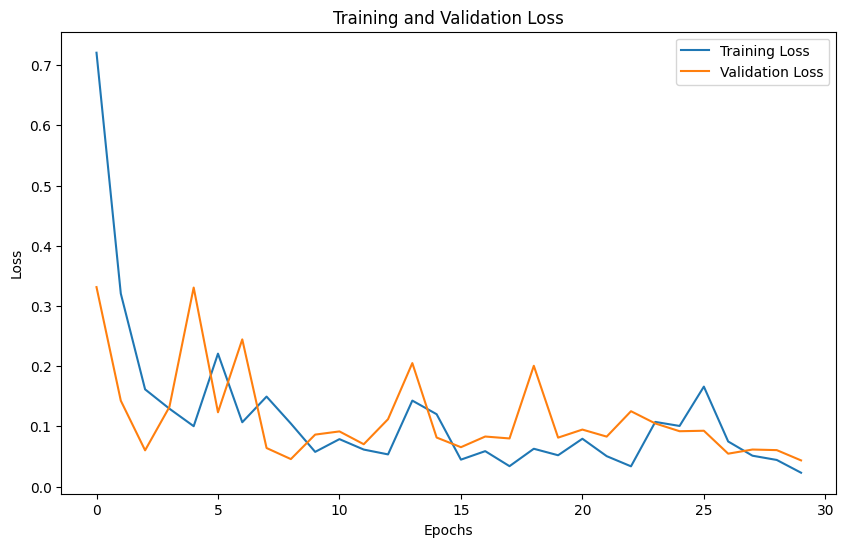

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


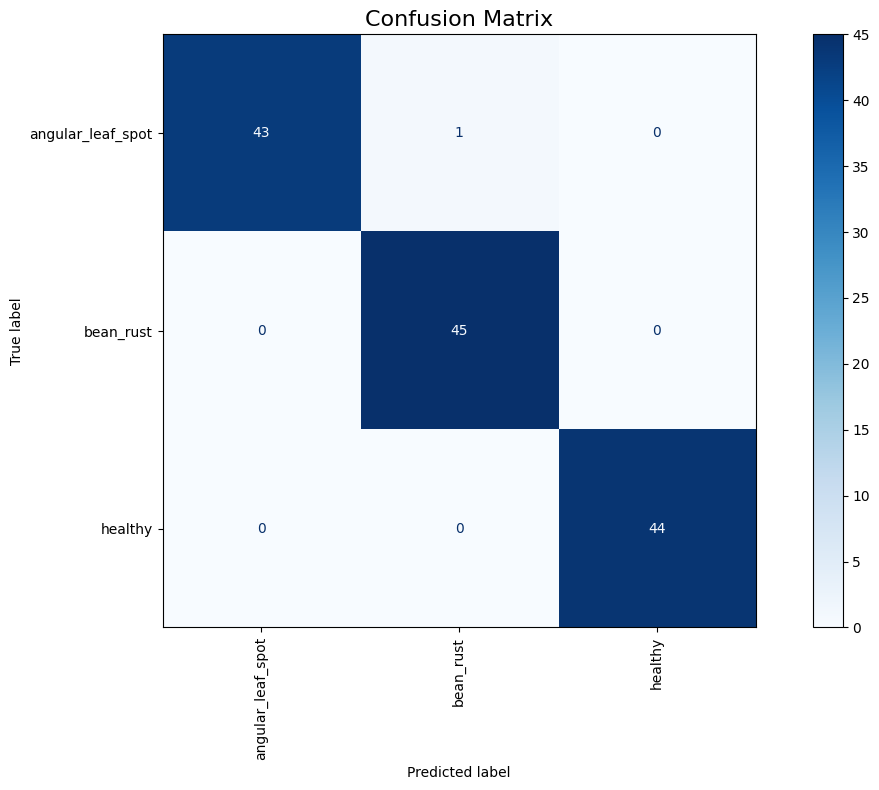

In [34]:
model_name = "EfficientNetV2B3"
skema = "EN Original 30%T imagenet"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EN Original 100%T None

In [35]:
trainable_percentage = 1
batch_size = 32

#### EfficientNetV2B0

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4211 - loss: 1.2167 - val_accuracy: 0.5098 - val_loss: 1.2923
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 463ms/step - accuracy: 0.5070 - loss: 0.9860 - val_accuracy: 0.5000 - val_loss: 0.9312
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 519ms/step - accuracy: 0.5753 - loss: 0.8978 - val_accuracy: 0.5098 - val_loss: 4.2203
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.5973 - loss: 0.8855 - val_accuracy: 0.5980 - val_loss: 0.7573
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 494ms/step - accuracy: 0.5755 - loss: 0.8810 - val_accuracy: 0.6569 - val_loss: 0.7047
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 401ms/step - accuracy: 0.6943 - loss: 0.8020 - val_accuracy: 0.6765 - val_loss: 0.7136
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.6567 - loss: 0.7905 - val_accuracy: 0.6569 - val_loss: 0.6514
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - accuracy: 0.6969 - loss: 0.7312 - val_accura

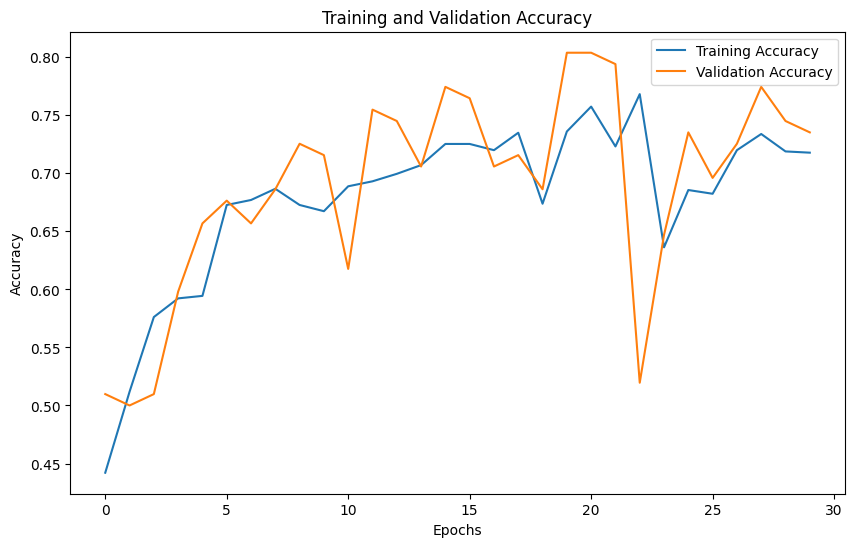

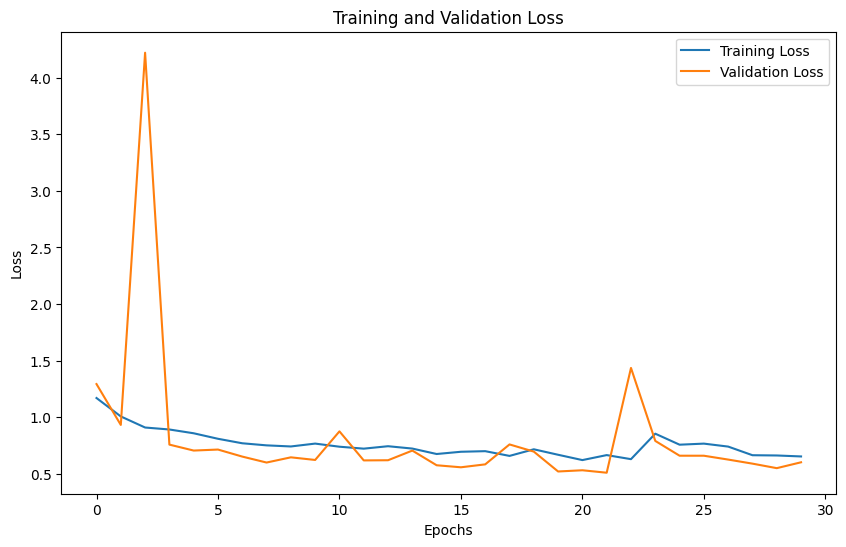

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


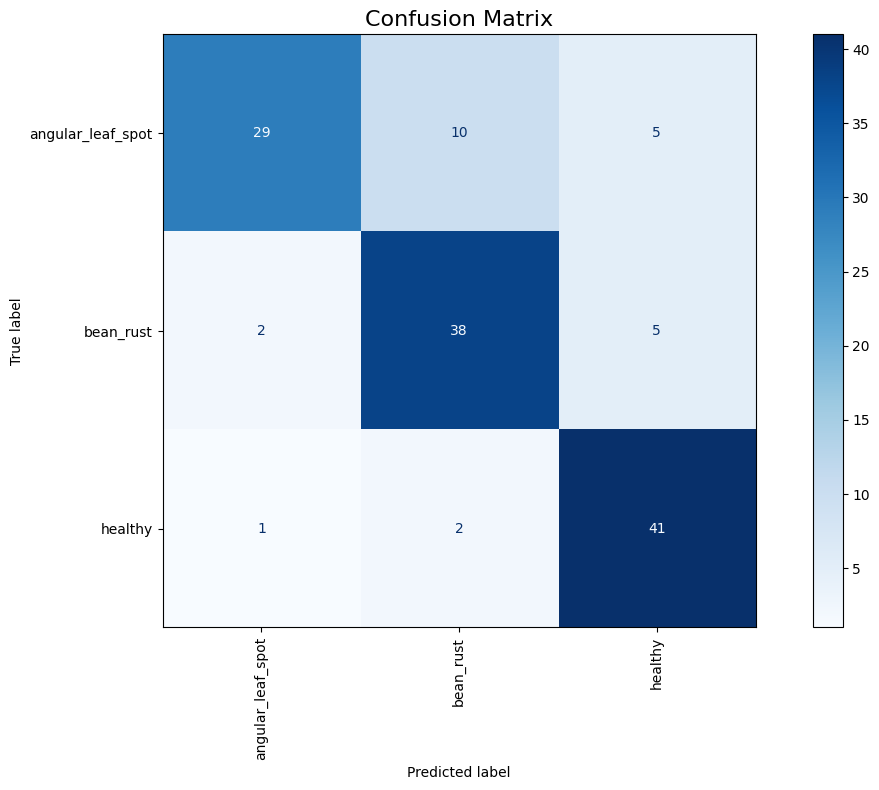

In [36]:
model_name = "EfficientNetV2B0"
skema = "EN Original 100%T None"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B1

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.3794 - loss: 1.1933 - val_accuracy: 0.5686 - val_loss: 1.4809
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 532ms/step - accuracy: 0.5351 - loss: 1.0855 - val_accuracy: 0.6176 - val_loss: 1.0036
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 598ms/step - accuracy: 0.4910 - loss: 1.0739 - val_accuracy: 0.6176 - val_loss: 0.8847
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 744ms/step - accuracy: 0.6020 - loss: 0.8950 - val_accuracy: 0.6471 - val_loss: 0.9570
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 686ms/step - accuracy: 0.6107 - loss: 0.9207 - val_accuracy: 0.6765 - val_loss: 0.8106
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 657ms/step - accuracy: 0.5919 - loss: 0.9022 - val_accuracy: 0.6667 - val_loss: 0.7586
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 684ms/step - accuracy: 0.6425 - loss: 0.8497 - val_accuracy: 0.6863 - val_loss: 0.7956
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 579ms/step - accuracy: 0.6412 - loss: 0.8651 - val_accura

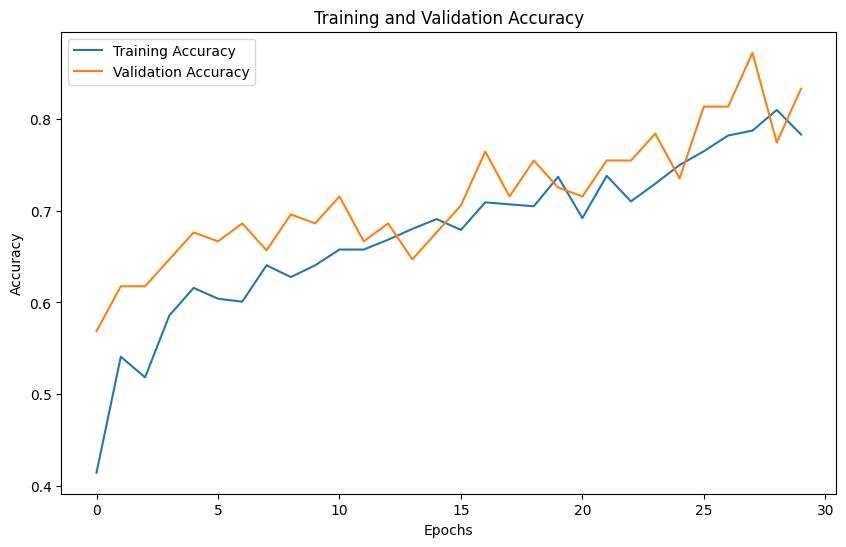

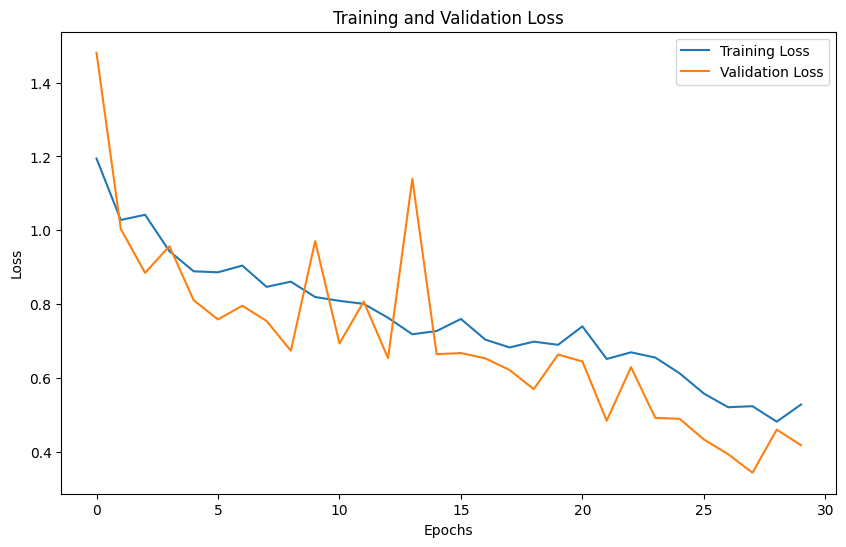

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step


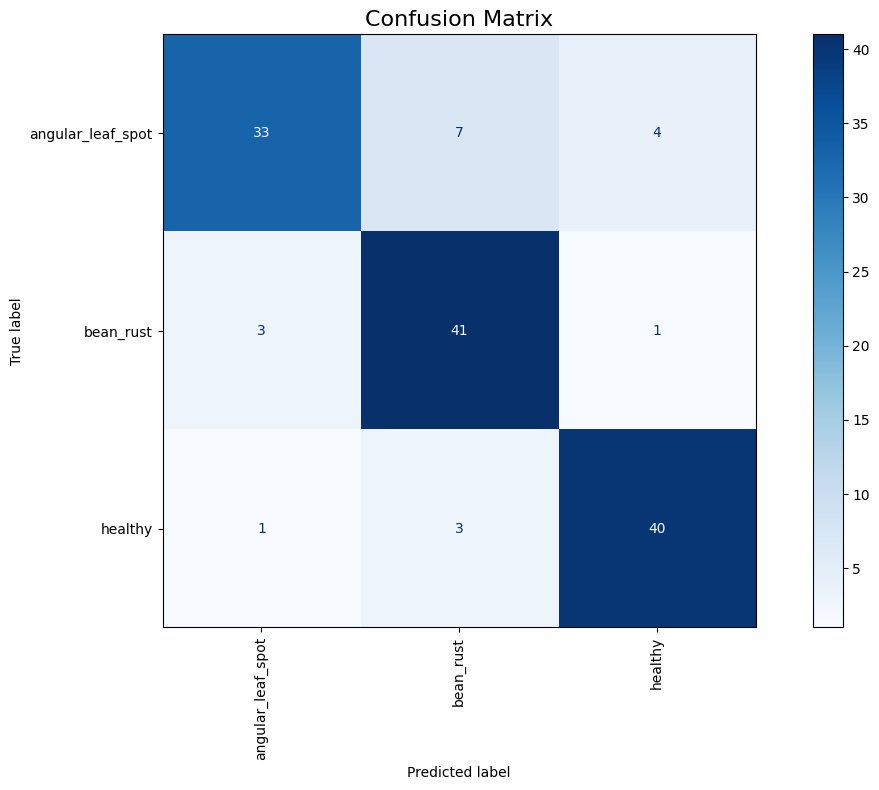

In [37]:
model_name = "EfficientNetV2B1"
skema = "EN Original 100%T None"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B2

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.3212 - loss: 1.2810 - val_accuracy: 0.3627 - val_loss: 1.1111
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.3771 - loss: 1.1552 - val_accuracy: 0.5392 - val_loss: 1.0062
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 610ms/step - accuracy: 0.5552 - loss: 0.9763 - val_accuracy: 0.6176 - val_loss: 0.8875
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 593ms/step - accuracy: 0.5501 - loss: 0.9855 - val_accuracy: 0.6078 - val_loss: 1.1272
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 567ms/step - accuracy: 0.6087 - loss: 0.8772 - val_accuracy: 0.6373 - val_loss: 0.8310
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.6148 - loss: 0.9056 - val_accuracy: 0.6373 - val_loss: 0.8709
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 572ms/step - accuracy: 0.6450 - loss: 0.8434 - val_accuracy: 0.6863 - val_loss: 0.7353
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 596ms/step - accuracy: 0.6561 - loss: 0.8545 - val_accura

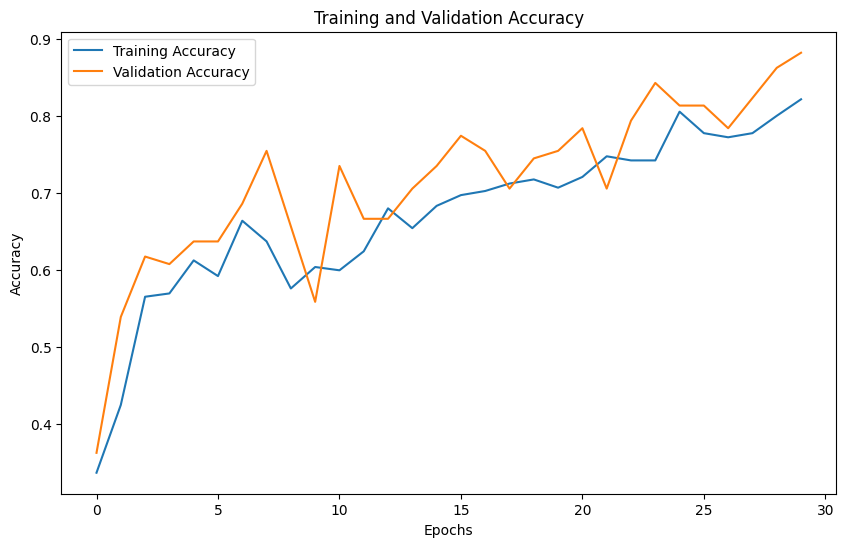

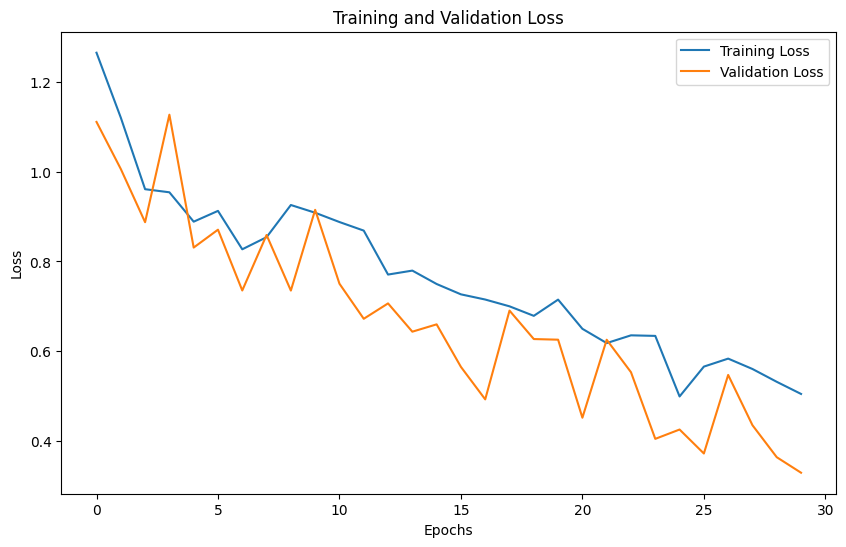

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step


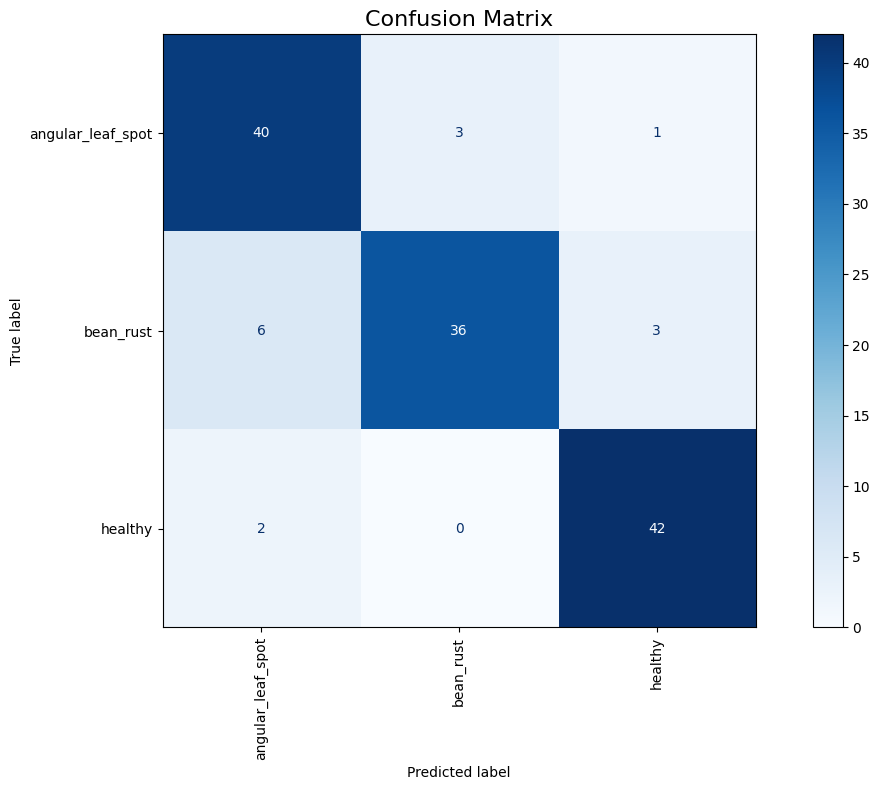

In [38]:
model_name = "EfficientNetV2B2"
skema = "EN Original 100%T None"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B3

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.3570 - loss: 1.2014 - val_accuracy: 0.4706 - val_loss: 1.1562
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - accuracy: 0.5118 - loss: 1.0110 - val_accuracy: 0.6078 - val_loss: 1.4773
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 747ms/step - accuracy: 0.4707 - loss: 1.0315 - val_accuracy: 0.5294 - val_loss: 3.0609
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.5423 - loss: 0.9356 - val_accuracy: 0.5294 - val_loss: 0.8195
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 730ms/step - accuracy: 0.5594 - loss: 0.8937 - val_accuracy: 0.5980 - val_loss: 0.8137
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 759ms/step - accuracy: 0.6233 - loss: 0.8146 - val_accuracy: 0.5392 - val_loss: 0.8809
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 813ms/step - accuracy: 0.6107 - loss: 0.8783 - val_accuracy: 0.6176 - val_loss: 0.7900
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 792ms/step - accuracy: 0.5183 - loss: 1.0266 - val_accura

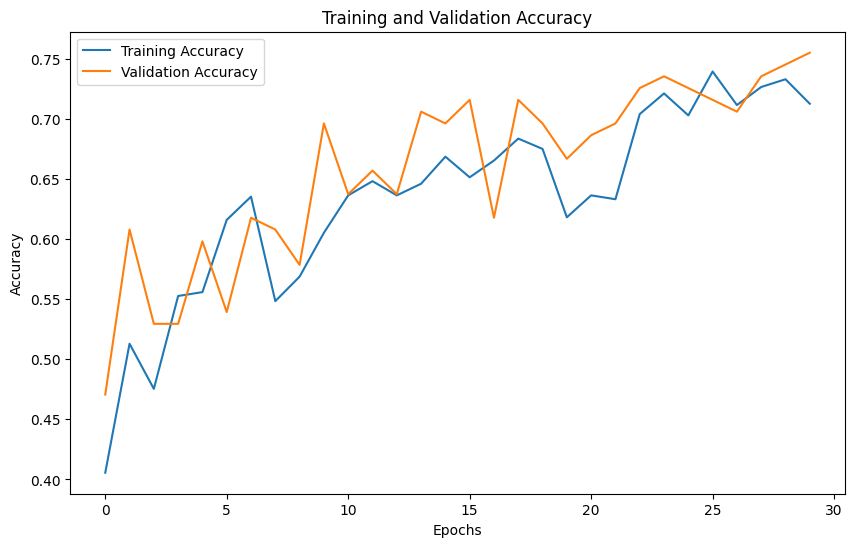

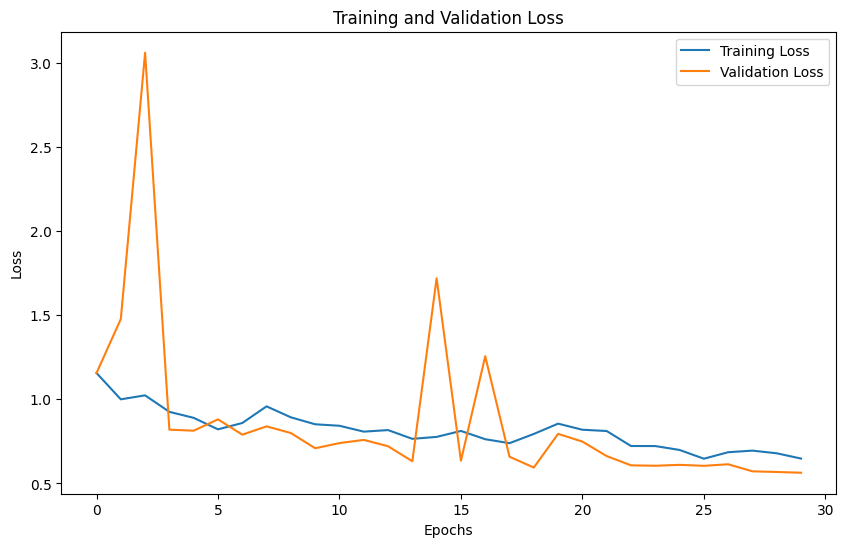

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


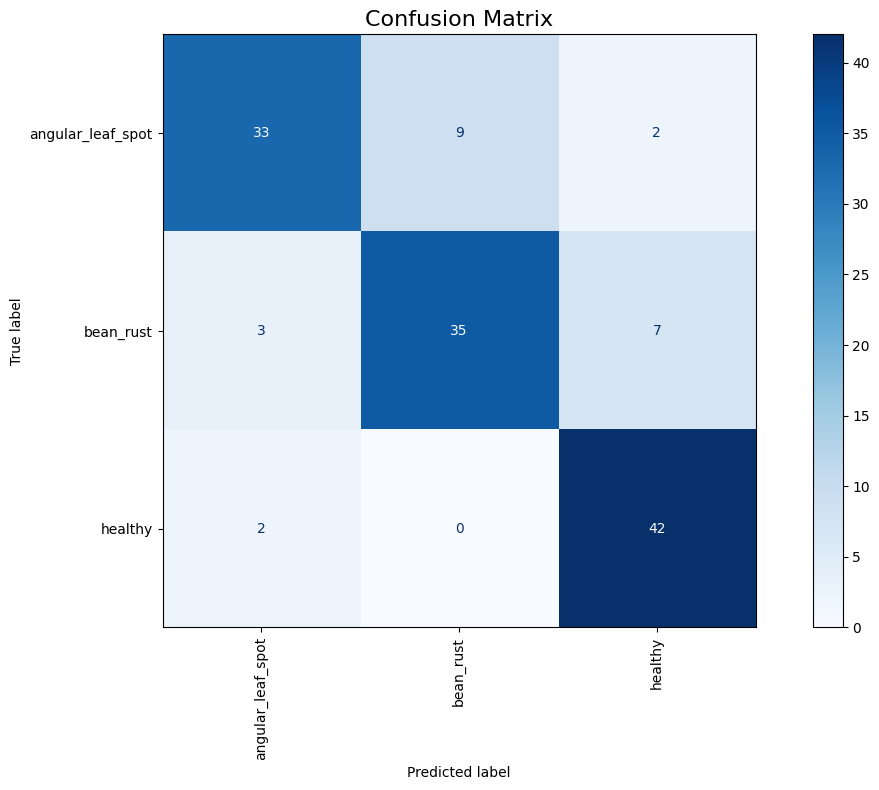

In [39]:
model_name = "EfficientNetV2B3"
skema = "EN Original 100%T None"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

### EN Mod 100%T None

In [40]:
trainable_percentage = 1
batch_size = 32

#### EfficientNetV2B0Modifikasi

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4779 - loss: 1.0423 - val_accuracy: 0.6078 - val_loss: 0.9050
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 505ms/step - accuracy: 0.6276 - loss: 0.8253 - val_accuracy: 0.7059 - val_loss: 0.7089
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.6936 - loss: 0.7896 - val_accuracy: 0.7451 - val_loss: 0.6495
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 473ms/step - accuracy: 0.6070 - loss: 0.8528 - val_accuracy: 0.5686 - val_loss: 0.9387
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.6792 - loss: 0.7652 - val_accuracy: 0.7157 - val_loss: 0.6947
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 460ms/step - accuracy: 0.7105 - loss: 0.7027 - val_accuracy: 0.7157 - val_loss: 0.7396
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.7013 - loss: 0.6954 - val_accuracy: 0.6471 - val_loss: 0.8549
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 486ms/step - accuracy: 0.6602 - loss: 0.7558 - val_accurac

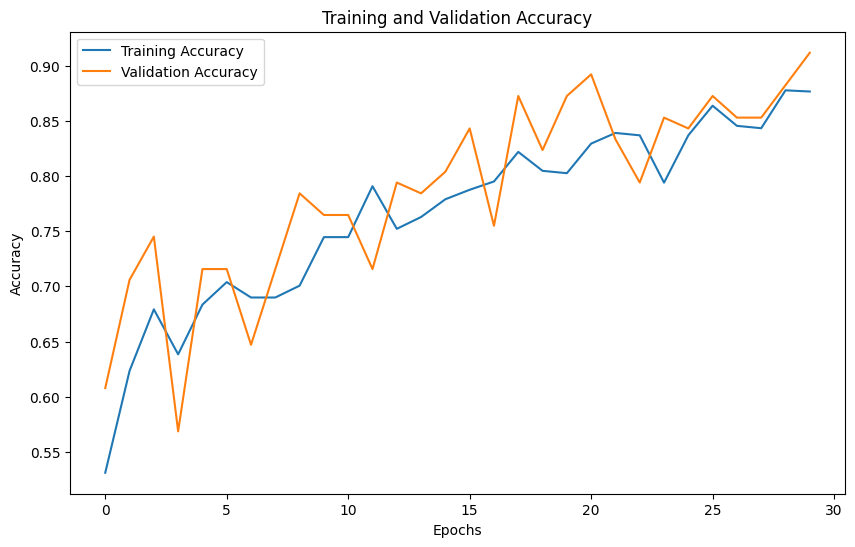

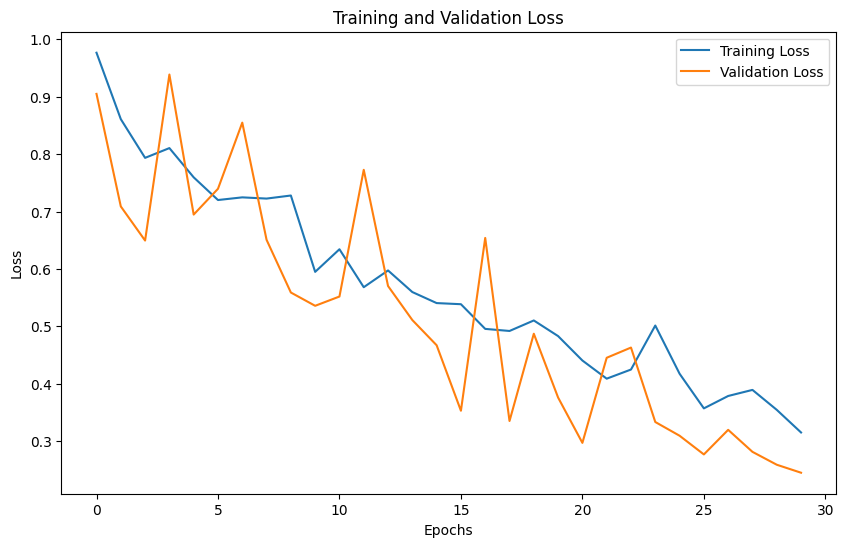

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step


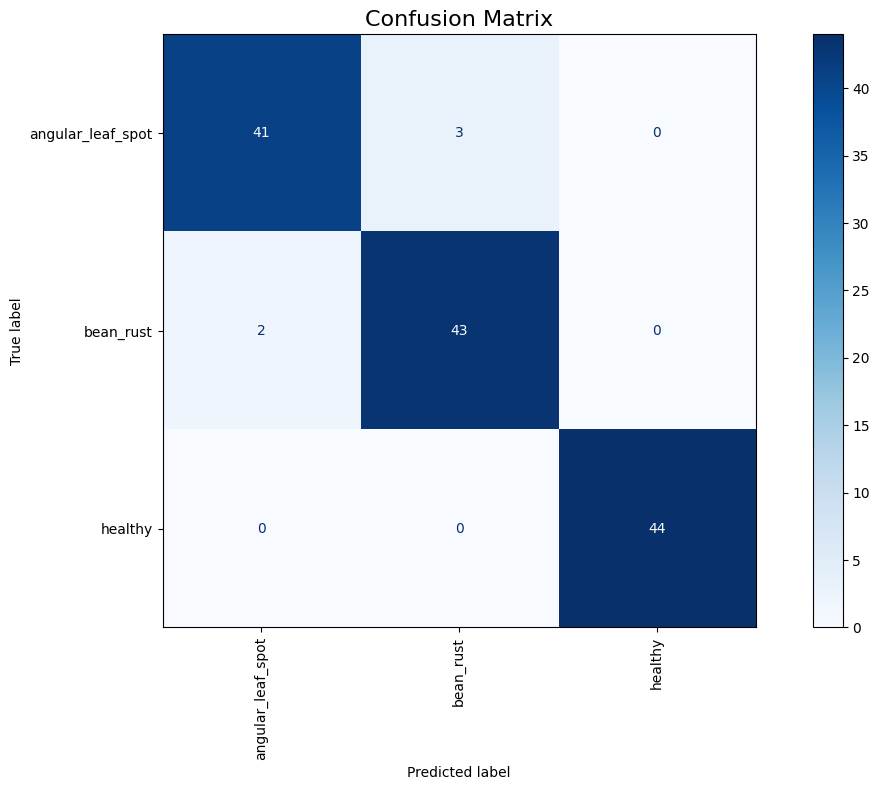

In [41]:
model_name = "EfficientNetV2B0Modifikasi"
skema = "EN Mod 100%T None"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B1Modifikasi

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4371 - loss: 1.1136 - val_accuracy: 0.6569 - val_loss: 0.8096
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 872ms/step - accuracy: 0.6303 - loss: 0.8863 - val_accuracy: 0.6373 - val_loss: 0.8333
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 598ms/step - accuracy: 0.6262 - loss: 0.8797 - val_accuracy: 0.6667 - val_loss: 0.9631
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 647ms/step - accuracy: 0.6524 - loss: 0.8212 - val_accuracy: 0.6961 - val_loss: 0.6886
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 638ms/step - accuracy: 0.6558 - loss: 0.7760 - val_accuracy: 0.7451 - val_loss: 0.6756
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.6779 - loss: 0.7552 - val_accuracy: 0.6765 - val_loss: 0.7192
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 653ms/step - accuracy: 0.6982 - loss: 0.7401 - val_accuracy: 0.7255 - val_loss: 0.5952
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 648ms/step - accuracy: 0.7175 - loss: 0.6956 - val_accurac

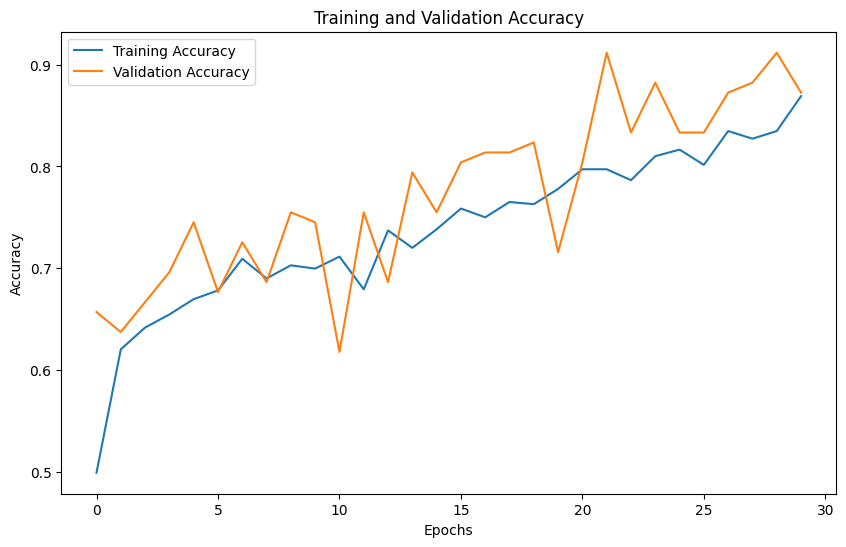

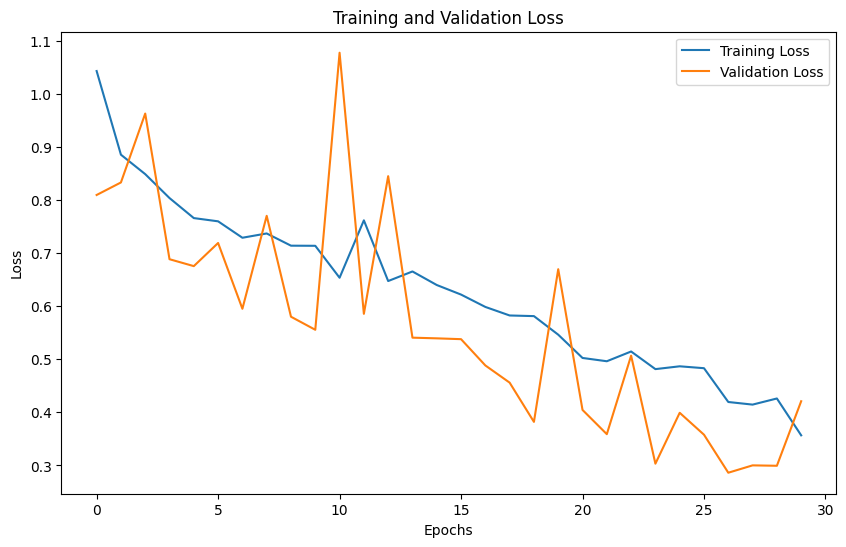

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


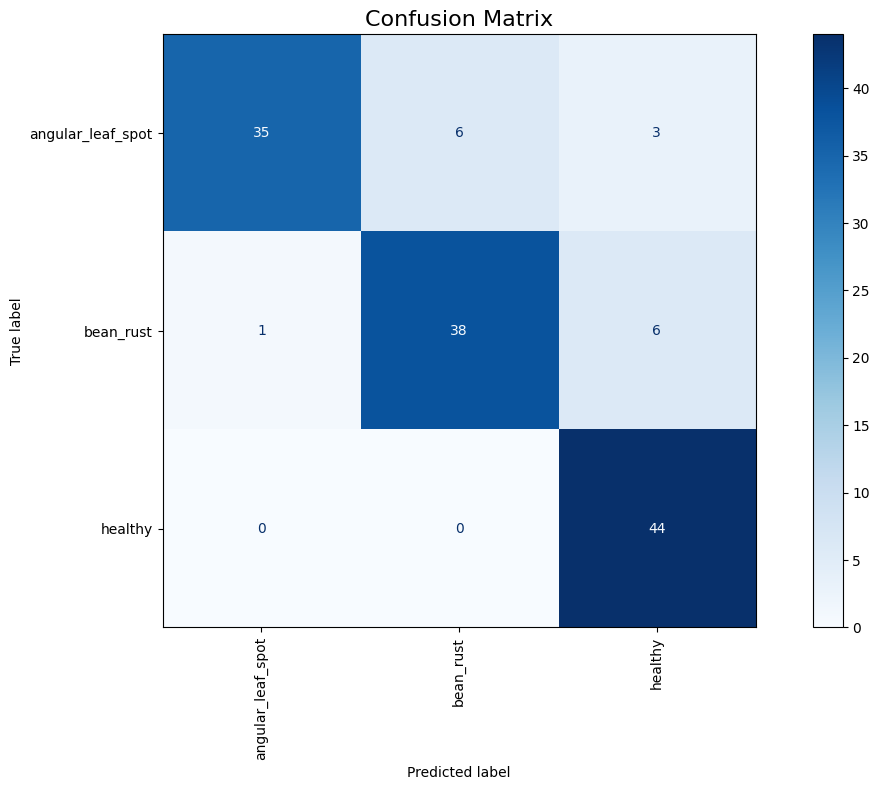

In [42]:
model_name = "EfficientNetV2B1Modifikasi"
skema = "EN Mod 100%T None"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B2Modifikasi

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4862 - loss: 1.1193 - val_accuracy: 0.5686 - val_loss: 1.2142
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 599ms/step - accuracy: 0.5471 - loss: 1.0829 - val_accuracy: 0.6667 - val_loss: 0.7648
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - accuracy: 0.5844 - loss: 0.8895 - val_accuracy: 0.6471 - val_loss: 0.8369
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 595ms/step - accuracy: 0.6257 - loss: 0.8413 - val_accuracy: 0.6667 - val_loss: 0.7533
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 601ms/step - accuracy: 0.6444 - loss: 0.7741 - val_accuracy: 0.7059 - val_loss: 0.6717
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 625ms/step - accuracy: 0.7036 - loss: 0.7400 - val_accuracy: 0.6471 - val_loss: 0.7449
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 626ms/step - accuracy: 0.6873 - loss: 0.7253 - val_accuracy: 0.7353 - val_loss: 0.5994
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 617ms/step - accuracy: 0.6941 - loss: 0.6767 - val_accurac

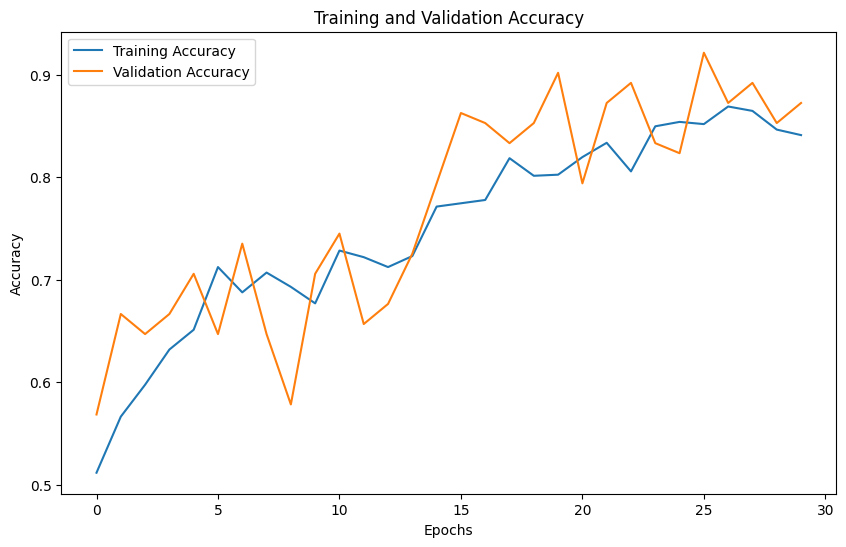

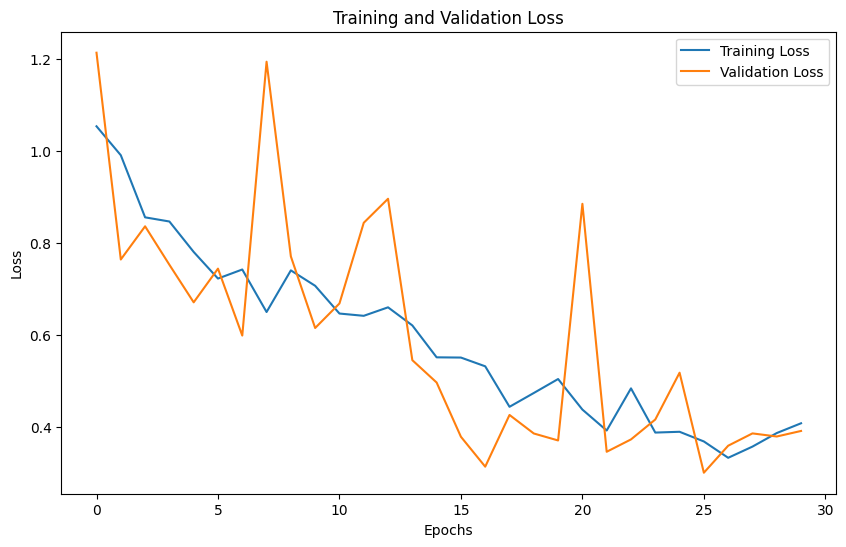

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


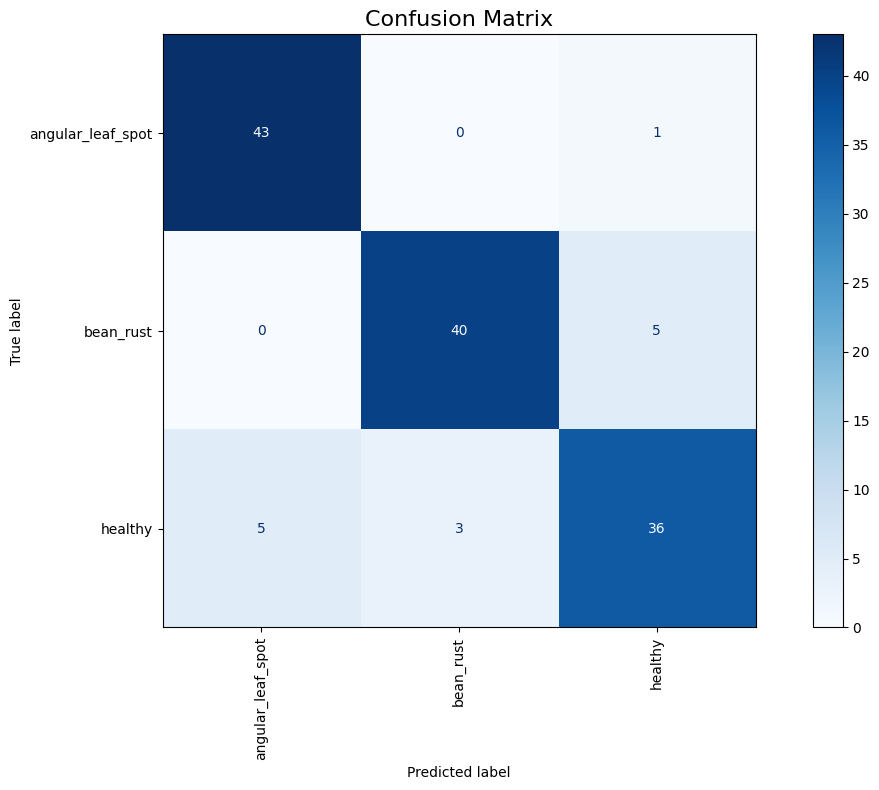

In [43]:
model_name = "EfficientNetV2B2Modifikasi"
skema = "EN Mod 100%T None"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### EfficientNetV2B3Modifikasi

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4257 - loss: 1.1106 - val_accuracy: 0.5784 - val_loss: 0.8286
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 734ms/step - accuracy: 0.6099 - loss: 0.8954 - val_accuracy: 0.4804 - val_loss: 1.0307
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - accuracy: 0.6024 - loss: 0.9152 - val_accuracy: 0.6863 - val_loss: 0.7268
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.6372 - loss: 0.8175 - val_accuracy: 0.5980 - val_loss: 0.9802
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 739ms/step - accuracy: 0.6745 - loss: 0.7627 - val_accuracy: 0.6275 - val_loss: 0.8725
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 722ms/step - accuracy: 0.6731 - loss: 0.7646 - val_accuracy: 0.7059 - val_loss: 0.7127
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.6508 - loss: 0.7624 - val_accuracy: 0.6961 - val_loss: 0.6509
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 756ms/step - accuracy: 0.6582 - loss: 0.7630 - val_accurac

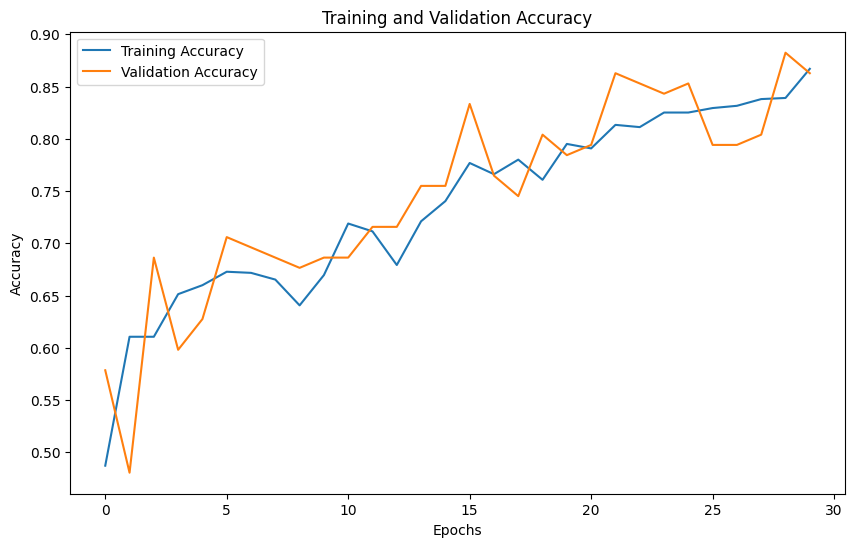

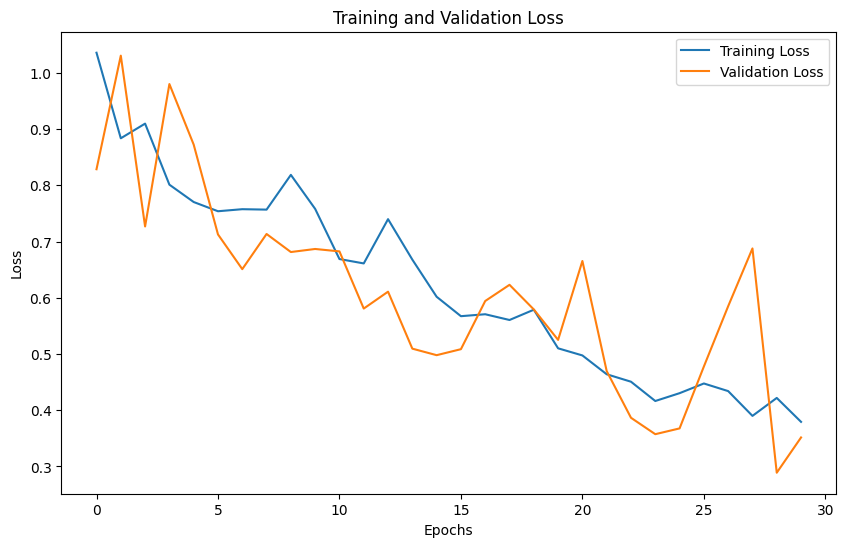

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step


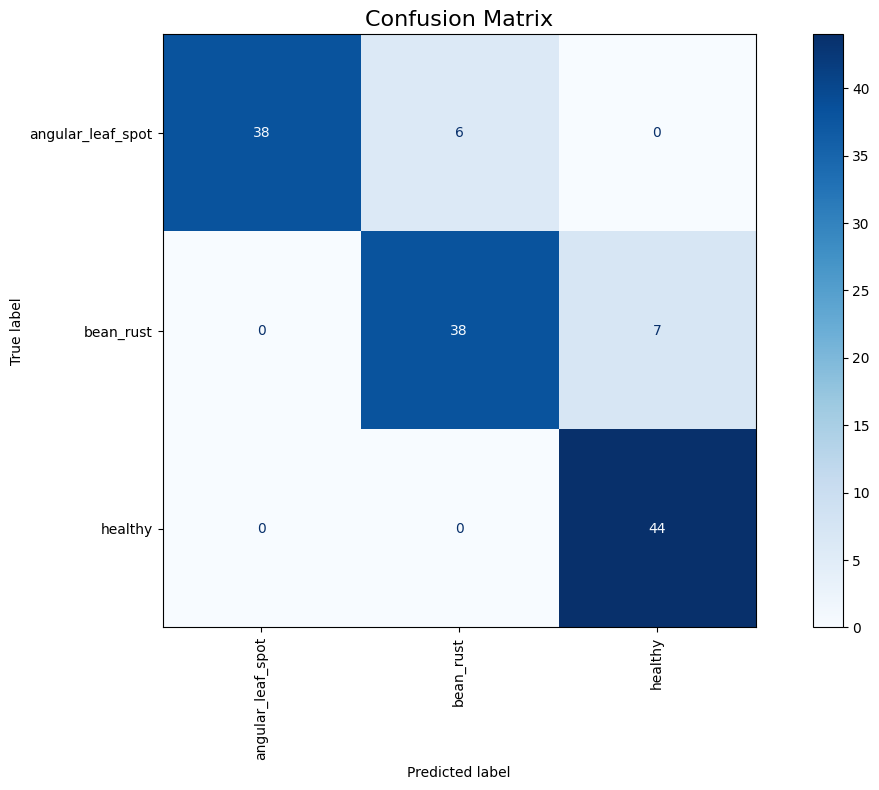

In [44]:
model_name = "EfficientNetV2B3Modifikasi"
skema = "EN Mod 100%T None"
# batch_size = 4

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

# Evaluation

## kFold

In [45]:
# def kfold_train(dataset_path, img_size, batch_size, epochs_size, model_name, best_model_dir, k=5):
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)
#     train_path = os.path.join(base_path, 'training')
#     class_names = os.listdir(train_path)
#     data_paths = []
#     labels = []

#     # Collect all image paths and labels
#     for class_index, class_name in enumerate(class_names):
#         class_folder = os.path.join(train_path, class_name)
#         for img_file in os.listdir(class_folder):
#             data_paths.append(os.path.join(class_folder, img_file))
#             labels.append(class_index)
    
#     data_paths = np.array(data_paths)
#     labels = np.array(labels)

#     for fold, (train_idx, val_idx) in enumerate(kf.split(data_paths), start=1):
#         print(f"Starting fold {fold}/{k}")

#         # Split data into train and validation sets based on KFold indices
#         train_data_paths = data_paths[train_idx]
#         train_labels = labels[train_idx].astype(str)
#         val_data_paths = data_paths[val_idx]
#         val_labels = labels[val_idx].astype(str)

#         # Build model for the current fold
#         num_classes = len(np.unique(train_labels))  # Get unique class count
#         model = load_base_model("MobileNetV3Small", img_size, img_size, trainable_percentage=0.3)
#         model = build_model(model, num_classes)
#         compile_model(model, learning_rate)

#         # Train model and save results for each fold
#         history, training_duration = train_model(model, train_generator, val_generator, epochs)
        
#         test_loss, test_accuracy = evaluate_model(model, test_generator)

#         print(f"Test acc: {test_accuracy}")

#         print(f"Completed fold {fold}/{k}")

In [46]:
# model_name = "MobileNetV3Small"
# best_model_dir = "results/best_model/classifier_2024-12-16 23:03:20.h5"

# # Run k-fold cross-validation
# kfold_train(
#     dataset_path,
#     img_height,
#     batch_size,
#     epochs_size,
#     model_name,
#     best_model_dir,
#     k=5 
# )